In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

# Zip dosyasının yolu
zip_path = '/content/drive/MyDrive/DataSource/isic-2019.zip'

# Çıkarma yolu
extract_path = '/content/drive/MyDrive/isic-2019(1)/'

# Zip dosyasını çıkarma
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
import pandas as pd
import numpy as np
import time
import random
from tqdm import tqdm
import os
import cv2
import re
import matplotlib.pyplot as plt
from glob import glob
import tensorflow_hub as hub
import tensorflow as tf
import time
from PIL import Image
import imgaug as ia
import imgaug.augmenters as iaa
from tensorflow.keras.utils import load_img
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix
from albumentations import RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip, RandomBrightnessContrast, ShiftScaleRotate, Rotate

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Hiperparametreler
hp = {}
hp['image_size'] = 512
hp['num_channels'] = 3
hp['batch_size'] = 32
hp['lr'] = 1e-4
hp["num_epochs"] = 30
hp['num_classes'] = 7
hp['dropout_rate'] = 0.1
hp['class_names'] = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC"]

In [ ]:
# Veriyi oku
md = pd.read_csv('/content/drive/MyDrive/DataSource/ISIC_2019_Training_GroundTruth.csv')
md.head()

image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0

In [ ]:
md.shape

(25331, 10)

In [ ]:
# Veri setinden farklı sınıfları ayır
mel_images = md.loc[md['MEL'] == 1, 'image'].tolist()
nv_images = md.loc[md['NV'] == 1, 'image'].tolist()
bcc_images = md.loc[md['BCC'] == 1, 'image'].tolist()
ak_images = md.loc[md['AK'] == 1, 'image'].tolist()
bkl_images = md.loc[md['BKL'] == 1, 'image'].tolist()
df_images = md.loc[md['DF'] == 1, 'image'].tolist()
vasc_images = md.loc[md['VASC'] == 1, 'image'].tolist()

# Verilerin uzunlukları
mel_count = len(mel_images)
nv_count = len(nv_images)
bcc_count = len(bcc_images)
ak_count = len(ak_images)
bkl_count = len(bkl_images)
df_count = len(df_images)
vasc_count = len(vasc_images)

print(mel_count, nv_count, bcc_count, ak_count, bkl_count, df_count, vasc_count)

4522 12875 3323 867 2624 239 253


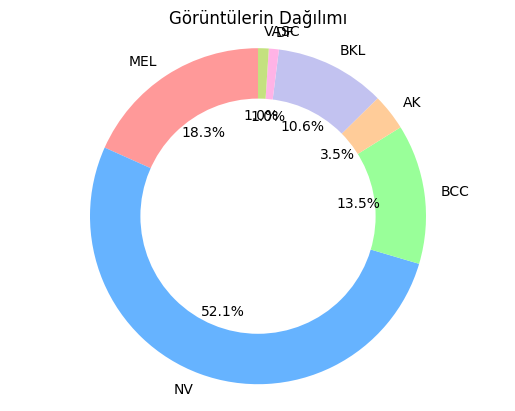

In [ ]:
# Etiketler ve sayılar
labels = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC']
sizes = [mel_count, nv_count, bcc_count, ak_count, bkl_count, df_count, vasc_count]

# Pasta grafiği çiz
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#c4e17f']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')
plt.title('Görüntülerin Dağılımı')
plt.show()


In [ ]:
# Her sınıf için görüntü dosyalarını depolamak için listeler oluştur
MEL = []
NV = []
BCC = []
AK = []
BKL = []
DF = []
VASC = []

path = "/content/drive/MyDrive/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input"
for i in os.listdir(path):
    if '.' in i:
        name = i.split('.')[-2]
        if name in mel_images:
            MEL.append(os.path.join(path, i))
        elif name in nv_images:
            NV.append(os.path.join(path, i))
        elif name in bcc_images:
            BCC.append(os.path.join(path, i))
        elif name in ak_images:
            AK.append(os.path.join(path, i))
        elif name in bkl_images:
            BKL.append(os.path.join(path, i))
        elif name in df_images:
            DF.append(os.path.join(path, i))
        elif name in vasc_images:
            VASC.append(os.path.join(path, i))


# Her sınıfın uzunluğunu hesapla
print(len(MEL), len(NV), len(BCC), len(AK), len(BKL), len(DF), len(VASC))

4522 12875 3323 867 2624 239 253


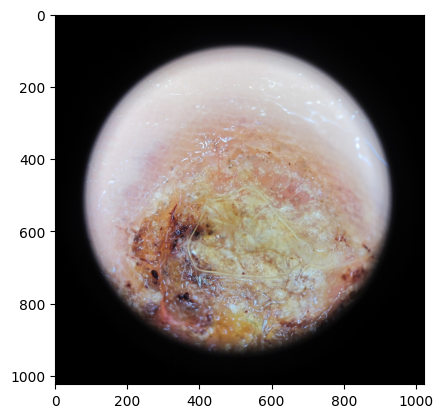

In [ ]:
img = cv2.imread(MEL[97])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

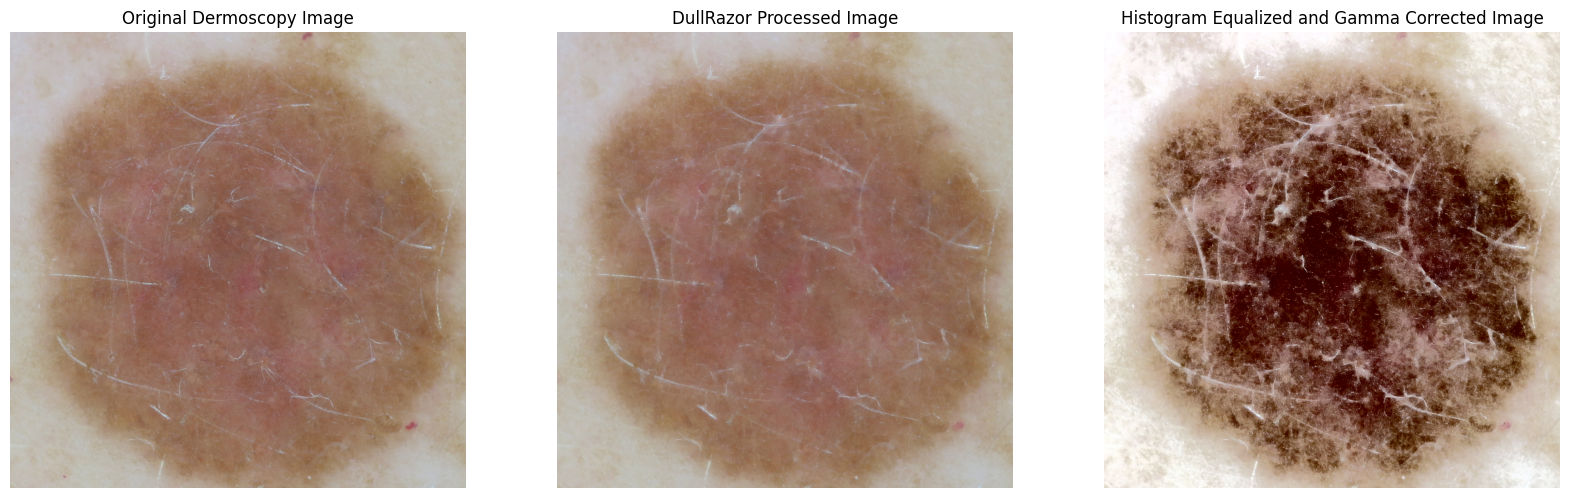

In [ ]:

# Apply DullRazor function
def apply_dullrazor(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray_scale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    blackhat = cv2.morphologyEx(gray_scale, cv2.MORPH_BLACKHAT, kernel)
    bhg = cv2.GaussianBlur(blackhat, (3, 3), cv2.BORDER_DEFAULT)
    ret, mask = cv2.threshold(bhg, 10, 255, cv2.THRESH_BINARY)
    dst = cv2.inpaint(img, mask, 6, cv2.INPAINT_TELEA)
    return img, dst

# Apply histogram equalization
def apply_histogram_equalization(image):
    img_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    return img_output

# Apply gamma correction
def apply_gamma_correction(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# İşlemi uygula ve sonuçları görselleştir
original, processed = apply_dullrazor(MEL[100])
equalized = apply_histogram_equalization(processed)
gamma_corrected = apply_gamma_correction(equalized, gamma=1.2)

plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(original)
plt.title('Original Dermoscopy Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(processed)
plt.title('DullRazor Processed Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(gamma_corrected)
plt.title('Histogram Equalized and Gamma Corrected Image')
plt.axis('off')

plt.show()


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
import time

# Varsayılan apply_dullrazor fonksiyonu örneği
def apply_dullrazor(image_path):
    img = cv2.imread(image_path)
    original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # DullRazor işlemi burada yapılmalı (placeholder)
    processed = original  # Asıl işlem yapılmalı
    return original, processed


In [ ]:
os.makedirs('/kaggle/working/preprocessed', exist_ok=True)

In [ ]:
original_images = []
processed_images = []

# 7 sınıf için örnek görüntüleri alalım
img_list = MEL[90:95] + NV[90:95] + BCC[90:95] + AK[90:95] + BKL[90:95] + DF[90:95] + VASC[90:95]
print(len(img_list))

for i, filename in enumerate(img_list):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Apply the function
        original, processed = apply_dullrazor(filename)
        cv2.imwrite(f"/kaggle/working/preprocessed/img_{i}.png", processed)

        # Append to the lists
        original_images.append(original)
        processed_images.append(processed)

fig, axs = plt.subplots(len(original_images), 2, figsize=(10, 5 * len(original_images)))

for i in range(len(original_images)):
    axs[i, 0].imshow(original_images[i])
    axs[i, 0].set_title(f'Original Image {i}')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(processed_images[i])
    axs[i, 1].set_title('Processed Image')
    axs[i, 1].axis('off')
plt.show()


Output hidden; open in https://colab.research.google.com to view.

(-0.5, 1023.5, 1023.5, -0.5)

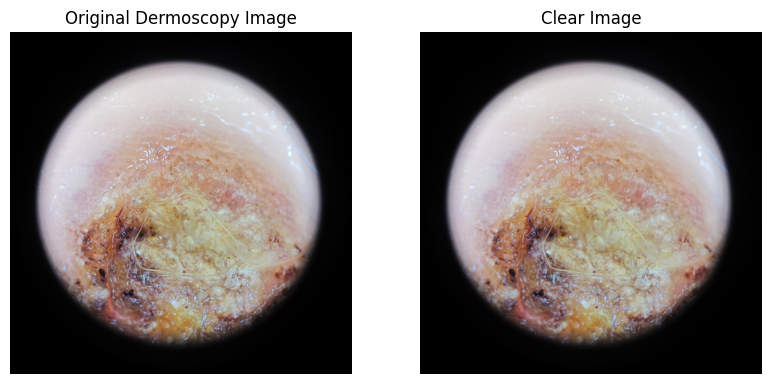

In [ ]:
def restore_blurred_image_tikhonov(blurred_image, blur_kernel, regularization_lambda):
    restored_image = cv2.deblur(blurred_image, blur_kernel, regularization_lambda)
    return restored_image

blurred_image = cv2.imread(MEL[97])
blurred_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB)
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
blur_kernel = np.array([[1, 2, 1],
                        [2, 4, 2],
                        [1, 2, 1]]) / 16.0

image_sharp = cv2.filter2D(src=blurred_image, ddepth=-1, kernel=blur_kernel)

plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.imshow(blurred_image)
plt.title('Original Dermoscopy Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_sharp)
plt.title('Clear Image')
plt.axis('off')



In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Hiperparametreler
image_size = 128
num_channels = 3
batch_size = 32
initial_lr = 1e-4
num_epochs = 20
num_classes = 7
dropout_rate = 0.1
class_names = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC"]
num_samples_per_class = 1000

# Veri yolları
mel_images = MEL
nv_images = NV
bcc_images = BCC
ak_images = AK
bkl_images = BKL
df_images = DF
vasc_images = VASC

# Sınıflardaki veri sayısını 1000'e tamamlayacak şekilde veri setini oluştur
all_images = []
labels = []

for images, label in zip([mel_images, nv_images, bcc_images, ak_images, bkl_images, df_images, vasc_images], class_names):
    num_samples = min(len(images), num_samples_per_class)
    all_images.extend(images[:num_samples])
    labels.extend([label] * num_samples)

# Etiketleri tamsayıya dönüştürme
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Veri setini eğitim ve test olarak bölmek
train_images, test_images, train_labels, test_labels = train_test_split(all_images, labels, test_size=0.2, random_state=42)

# Görüntüleri ve etiketleri yükleme
def load_images(image_paths, image_size):
    images = []
    for image_path in image_paths:
        img = Image.open(image_path)
        img = img.resize((image_size, image_size))
        img = np.array(img) / 255.0  # Normalizasyon
        images.append(img)
    return np.array(images)

train_images = load_images(train_images, image_size)
test_images = load_images(test_images, image_size)

# Model oluşturma
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, num_channels)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(dropout_rate),
    Dense(num_classes, activation='softmax')
])

# Modeli derleme
model.compile(optimizer=Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Modeli eğitme (başlangıçta donmuş taban model ile)
history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Temel modeli serbest bırakma ve daha düşük bir öğrenme oranı ile yeniden eğitme
model.trainable = True
model.compile(optimizer=Adam(learning_rate=initial_lr/10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Modeli tekrar eğitme
history_fine = model.fit(train_images, train_labels, epochs=num_epochs//2, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Model performansını değerlendirme
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/20
134/134 [==============================] - 12s 36ms/step - loss: 1.7398 - accuracy: 0.2783 - val_loss: 1.6425 - val_accuracy: 0.2957 - lr: 1.0000e-04
Epoch 2/20
134/134 [==============================] - 3s 23ms/step - loss: 1.5918 - accuracy: 0.3583 - val_loss: 1.5529 - val_accuracy: 0.3731 - lr: 1.0000e-04
Epoch 3/20
134/134 [==============================] - 3s 25ms/step - loss: 1.5129 - accuracy: 0.4031 - val_loss: 1.5263 - val_accuracy: 0.4226 - lr: 1.0000e-04
Epoch 4/20
134/134 [==============================] - 3s 22ms/step - loss: 1.4519 - accuracy: 0.4329 - val_loss: 1.4558 - val_accuracy: 0.4095 - lr: 1.0000e-04
Epoch 5/20
134/134 [==============================] - 3s 22ms/step - loss: 1.4063 - accuracy: 0.4504 - val_loss: 1.4293 - val_accuracy: 0.4366 - lr: 1.0000e-04
Epoch 6/20
134/134 [==============================] - 3s 22ms/step - loss: 1.3643 - accuracy: 0.4672 - val_loss: 1.4238 - val_accuracy: 0.4328 - lr: 1.0000e-04
Epoch 7/20
134/134 [===================

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

# Hiperparametreler
image_size = 128
num_channels = 3
batch_size = 32
initial_lr = 1e-4
num_epochs = 20
num_classes = 7
dropout_rate = 0.1
class_names = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC"]
num_samples_per_class = 1000

# Veri yolları
mel_images = MEL
nv_images = NV
bcc_images = BCC
ak_images = AK
bkl_images = BKL
df_images = DF
vasc_images = VASC

# Sınıflardaki veri sayısını 1000'e tamamlayacak şekilde veri setini oluştur
all_images = []
labels = []

for images, label in zip([mel_images, nv_images, bcc_images, ak_images, bkl_images, df_images, vasc_images], class_names):
    num_samples = min(len(images), num_samples_per_class)
    all_images.extend(images[:num_samples])
    labels.extend([label] * num_samples)

# Etiketleri tamsayıya dönüştürme
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Veri setini eğitim ve test olarak bölmek
train_images, test_images, train_labels, test_labels = train_test_split(all_images, labels, test_size=0.2, random_state=42)

# Görüntüleri ve etiketleri yükleme
def load_images(image_paths, image_size):
    images = []
    for image_path in image_paths:
        img = Image.open(image_path)
        img = img.resize((image_size, image_size))
        img = np.array(img) / 255.0  # Normalizasyon
        images.append(img)
    return np.array(images)

train_images = load_images(train_images, image_size)
test_images = load_images(test_images, image_size)

# Veri artırma (Data Augmentation)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Model oluşturma
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, num_channels)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),  # Daha derin bir model
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(1024, activation='relu'),  # Daha büyük Dense katmanı
    Dropout(dropout_rate),
    Dense(num_classes, activation='softmax')
])

# Modeli derleme
model.compile(optimizer=Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Modeli eğitme (başlangıçta donmuş taban model ile)
history = model.fit(datagen.flow(train_images, train_labels, batch_size=batch_size),
                    epochs=num_epochs,
                    validation_data=(test_images, test_labels),
                    callbacks=[early_stopping, reduce_lr])

# Modelin tüm katmanlarını serbest bırak
for layer in model.layers:
    layer.trainable = True

# Modeli yeniden derleme
model.compile(optimizer=Adam(learning_rate=initial_lr / 10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Modeli tekrar eğitme
history_fine = model.fit(datagen.flow(train_images, train_labels, batch_size=batch_size),
                         epochs=num_epochs // 2,
                         validation_data=(test_images, test_labels),
                         callbacks=[early_stopping, reduce_lr])

# Model performansını değerlendirme
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/20
134/134 [==============================] - 25s 165ms/step - loss: 2.1527 - accuracy: 0.3434 - val_loss: 4.4651 - val_accuracy: 0.0522 - lr: 1.0000e-04
Epoch 2/20
134/134 [==============================] - 19s 142ms/step - loss: 1.5862 - accuracy: 0.4075 - val_loss: 5.5449 - val_accuracy: 0.0709 - lr: 1.0000e-04
Epoch 3/20
134/134 [==============================] - 20s 151ms/step - loss: 1.4735 - accuracy: 0.4259 - val_loss: 2.8173 - val_accuracy: 0.2108 - lr: 1.0000e-04
Epoch 4/20
134/134 [==============================] - 19s 143ms/step - loss: 1.4120 - accuracy: 0.4430 - val_loss: 1.5756 - val_accuracy: 0.4300 - lr: 1.0000e-04
Epoch 5/20
134/134 [==============================] - 19s 142ms/step - loss: 1.3489 - accuracy: 0.4731 - val_loss: 1.4053 - val_accuracy: 0.4655 - lr: 1.0000e-04
Epoch 6/20
134/134 [==============================] - 20s 150ms/step - loss: 1.3335 - accuracy: 0.4796 - val_loss: 1.3310 - val_accuracy: 0.4813 - lr: 1.0000e-04
Epoch 7/20
134/134 [========

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Hiperparametreler
image_size = 128
num_channels = 3
batch_size = 32
lr = 1e-4
num_epochs = 20
num_classes = 7
dropout_rate = 0.1
class_names = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC"]
num_samples_per_class = 1000

# Veri yolları
mel_images = MEL
nv_images = NV
bcc_images = BCC
ak_images = AK
bkl_images = BKL
df_images = DF
vasc_images = VASC

# Sınıflardaki veri sayısını 1000'e tamamlayacak şekilde veri setini oluştur
all_images = []
labels = []

for images, label in zip([mel_images, nv_images, bcc_images, ak_images, bkl_images, df_images, vasc_images], class_names):
    num_samples = min(len(images), num_samples_per_class)
    all_images.extend(images[:num_samples])
    labels.extend([label] * num_samples)

# Etiketleri tamsayıya dönüştürme
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Veri setini eğitim ve test olarak bölmek
train_images, test_images, train_labels, test_labels = train_test_split(all_images, labels, test_size=0.2, random_state=42)

# Görüntüleri ve etiketleri yükleme
def load_images(image_paths, image_size):
    images = []
    for image_path in image_paths:
        img = Image.open(image_path)
        img = img.resize((image_size, image_size))
        img = np.array(img) / 255.0  # Normalizasyon
        images.append(img)
    return np.array(images)

train_images = load_images(train_images, image_size)
test_images = load_images(test_images, image_size)

# Model oluşturma
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, num_channels)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(dropout_rate),
    Dense(num_classes, activation='softmax')
])

# Modeli derleme
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitme
history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(test_images, test_labels), batch_size=batch_size)

# Model performansını değerlendirme
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/20
134/134 [==============================] - 12s 34ms/step - loss: 1.7690 - accuracy: 0.2827 - val_loss: 1.6571 - val_accuracy: 0.3293
Epoch 2/20
134/134 [==============================] - 3s 25ms/step - loss: 1.5911 - accuracy: 0.3562 - val_loss: 1.5149 - val_accuracy: 0.3778
Epoch 3/20
134/134 [==============================] - 3s 23ms/step - loss: 1.4900 - accuracy: 0.4007 - val_loss: 1.5477 - val_accuracy: 0.3890
Epoch 4/20
134/134 [==============================] - 3s 22ms/step - loss: 1.4314 - accuracy: 0.4269 - val_loss: 1.4447 - val_accuracy: 0.4216
Epoch 5/20
134/134 [==============================] - 3s 22ms/step - loss: 1.3651 - accuracy: 0.4542 - val_loss: 1.3991 - val_accuracy: 0.4599
Epoch 6/20
134/134 [==============================] - 3s 24ms/step - loss: 1.2903 - accuracy: 0.5013 - val_loss: 1.3760 - val_accuracy: 0.4701
Epoch 7/20
134/134 [==============================] - 3s 24ms/step - loss: 1.2296 - accuracy: 0.5232 - val_loss: 1.4072 - val_accuracy: 0.465

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.applications import MobileNetV2
from keras.optimizers import Adam

# Hiperparametreler
image_size = 128
num_channels = 3
batch_size = 32
lr = 1e-4
num_epochs = 30
num_classes = 7
dropout_rate = 0.1
class_names = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC"]
num_samples_per_class = 1000

# Veri yolları
mel_images = MEL
nv_images = NV
bcc_images = BCC
ak_images = AK
bkl_images = BKL
df_images = DF
vasc_images = VASC

# Sınıflardaki veri sayısını 1000'e tamamlayacak şekilde veri setini oluştur
all_images = []
labels = []

for images, label in zip([mel_images, nv_images, bcc_images, ak_images, bkl_images, df_images, vasc_images], class_names):
    num_samples = min(len(images), num_samples_per_class)
    all_images.extend(images[:num_samples])
    labels.extend([label] * num_samples)

# Etiketleri tamsayıya dönüştürme
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Veri setini eğitim ve test olarak bölmek
train_images, test_images, train_labels, test_labels = train_test_split(all_images, labels, test_size=0.2, random_state=42)

# Görüntüleri ve etiketleri yükleme
def load_images(image_paths, image_size):
    images = []
    for image_path in image_paths:
        img = Image.open(image_path)
        img = img.resize((image_size, image_size))
        img = np.array(img) / 255.0  # Normalizasyon
        images.append(img)
    return np.array(images)

train_images = load_images(train_images, image_size)
test_images = load_images(test_images, image_size)

# Önceden eğitilmiş MobileNetV2 modelini yükleme
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
base_model.trainable = False  # Önceden eğitilmiş ağırlıkları dondur

# Yeni bir model oluşturma
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(dropout_rate),
    Dense(num_classes, activation='softmax')
])

# Modeli derleme
model.compile(optimizer=Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitme
history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(test_images, test_labels), batch_size=batch_size)

# Model performansını değerlendirme
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/30
134/134 [==============================] - 8s 31ms/step - loss: 1.6198 - accuracy: 0.3702 - val_loss: 1.3726 - val_accuracy: 0.4571
Epoch 2/30
134/134 [==============================] - 3s 21ms/step - loss: 1.3161 - accuracy: 0.4915 - val_loss: 1.2923 - val_accuracy: 0.4935
Epoch 3/30
134/134 [==============================] - 3s 24ms/step - loss: 1.1951 - accuracy: 0.5428 - val_loss: 1.2580 - val_accuracy: 0.5075
Epoch 4/30
134/134 [==============================] - 3s 23ms/step - loss: 1.1109 - accuracy: 0.5813 - val_loss: 1.2253 - val_accuracy: 0.5252
Epoch 5/30
134/134 [==============================] - 3s 22ms/step - loss: 1.0319 - accuracy: 0.6160 - val_loss: 1.2026 - val_accuracy: 0.5317
Epoch 6/30
134/134 [==============================] - 3s 21ms/step - loss: 0.9689 - accuracy: 0.6454 - val_loss: 1.2285 - val_accuracy: 0.5326
Epoch 7/30
134/134 [==============================] - 3s 23ms/step - loss: 0.9151 - accuracy: 0.6662 - val_loss: 1.1951 - val_accuracy: 0.5438

34/34 [==============================] - 2s 20ms/step


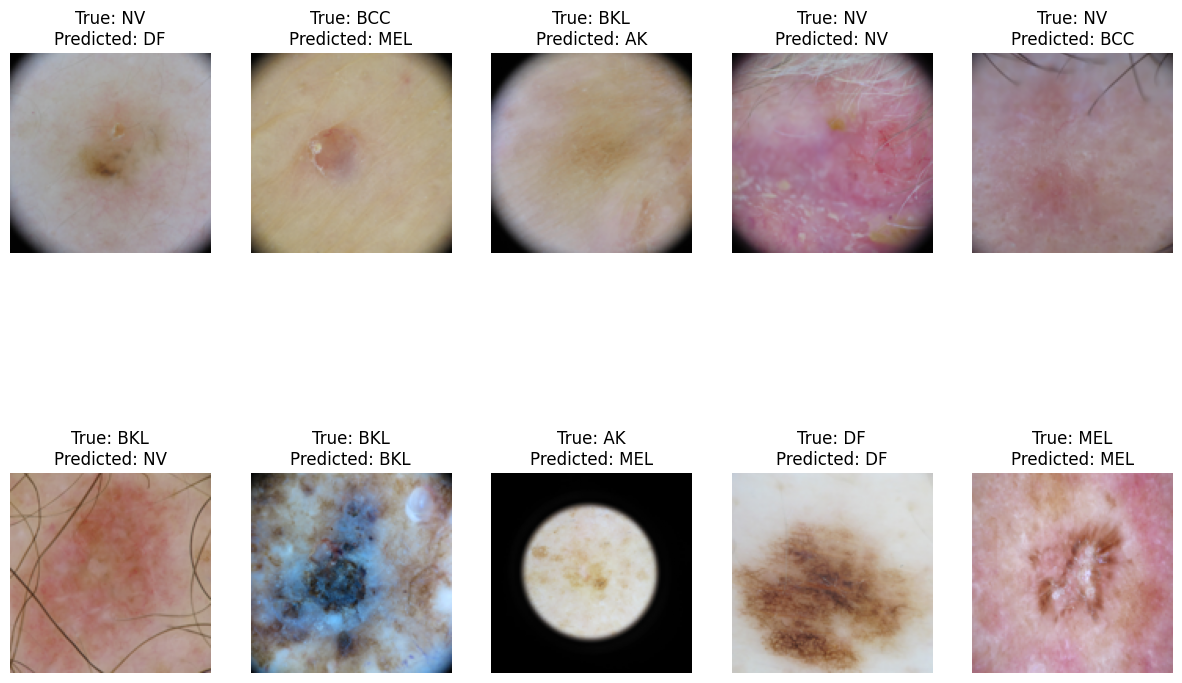

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(model, test_images, test_labels, class_names):
    # Modelin tahminlerini yap
    predictions = model.predict(test_images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Test veri kümesinden rastgele 10 örneği görselleştir
    plt.figure(figsize=(15, 10))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(test_images[i])
        plt.title(f"True: {class_names[test_labels[i]]}\nPredicted: {class_names[predicted_labels[i]]}")
        plt.axis('off')
    plt.show()

# Modelin tahminlerini görselleştir
visualize_predictions(model, test_images, test_labels, class_names)


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image, ImageEnhance
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator

# Hiperparametreler
image_size = 128
num_channels = 3
batch_size = 32
lr = 1e-4
num_epochs = 80
num_classes = 7
dropout_rate = 0.1
class_names = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC"]
num_samples_per_class = 2000

# Veri yolları
mel_images = MEL
nv_images = NV
bcc_images = BCC
ak_images = AK
bkl_images = BKL
df_images = DF
vasc_images = VASC

def augment_data(image_paths, target_count):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    augmented_images = []
    while len(augmented_images) < target_count:
        for image_path in image_paths:
            img = Image.open(image_path)
            img = img.resize((image_size, image_size))
            img_array = np.expand_dims(np.array(img) / 255.0, 0)
            i = 0
            for batch in datagen.flow(img_array, batch_size=1):
                augmented_images.append(batch[0])
                i += 1
                if len(augmented_images) >= target_count:
                    break
            if len(augmented_images) >= target_count:
                break
    return np.array(augmented_images)

# "DF", "AK" ve "VASC" sınıflarındaki veri sayısını 2000'e çıkarma
target_count = 2000
augmented_DF = augment_data(df_images, target_count)
augmented_AK = augment_data(ak_images, target_count)
augmented_VASC = augment_data(vasc_images, target_count)

# Diğer sınıflar için görüntüleri yükleme
def load_and_normalize_images(image_paths, image_size, num_samples):
    images = []
    for image_path in image_paths[:num_samples]:
        img = Image.open(image_path)
        img = img.resize((image_size, image_size))
        img = np.array(img) / 255.0  # Normalizasyon
        images.append(img)
    return np.array(images)

mel_images = load_and_normalize_images(mel_images, image_size, num_samples_per_class)
nv_images = load_and_normalize_images(nv_images, image_size, num_samples_per_class)
bcc_images = load_and_normalize_images(bcc_images, image_size, num_samples_per_class)
ak_images = augmented_AK[:num_samples_per_class]
bkl_images = load_and_normalize_images(bkl_images, image_size, num_samples_per_class)
df_images = augmented_DF[:num_samples_per_class]
vasc_images = augmented_VASC[:num_samples_per_class]

# Tüm görüntüleri ve etiketleri birleştirme
all_images = np.concatenate([mel_images, nv_images, bcc_images, ak_images, bkl_images, df_images, vasc_images])
labels = np.concatenate([[label] * num_samples_per_class for label in class_names])

# Etiketleri tamsayıya dönüştürme
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Veri setini eğitim ve test olarak bölmek
train_images, test_images, train_labels, test_labels = train_test_split(all_images, labels, test_size=0.2, random_state=42)

# Transfer learning kullanarak model oluşturma (örneğin, VGG16 modeli)
from keras.applications import VGG16
from keras.models import Model
from keras.layers import GlobalAveragePooling2D

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Modeli derleme
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitme
history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(test_images, test_labels), batch_size=batch_size)

# Model performansını değerlendirme
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/80
350/350 [==============================] - 21s 56ms/step - loss: 0.8165 - accuracy: 0.6855 - val_loss: 0.7092 - val_accuracy: 0.7046
Epoch 2/80
350/350 [==============================] - 18s 51ms/step - loss: 0.6330 - accuracy: 0.7459 - val_loss: 0.6201 - val_accuracy: 0.7507
Epoch 3/80
350/350 [==============================] - 18s 51ms/step - loss: 0.5973 - accuracy: 0.7596 - val_loss: 0.6203 - val_accuracy: 0.7432
Epoch 4/80
350/350 [==============================] - 18s 51ms/step - loss: 0.5655 - accuracy: 0.7758 - val_loss: 0.5813 - val_accuracy: 0.7714
Epoch 5/80
350/350 [==============================] - 18s 51ms/step - loss: 0.5537 - accuracy: 0.7784 - val_loss: 0.5945 - val_accuracy: 0.7682
Epoch 6/80
350/350 [==============================] - 18s 51ms/step - loss: 0.5435 - accuracy: 0.7820 - val_loss: 0.5847 - val_accuracy: 0.7600
Epoch 7/80
350/350 [==============================] - 18s 51ms/step - loss: 0.5315 - accuracy: 0.7842 - val_loss: 0.5641 - val_accuracy:

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.applications import VGG16, ResNet50, InceptionV3, Xception, DenseNet121, NASNetMobile, MobileNetV2
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Hiperparametreler
image_size = 128
num_channels = 3
batch_size = 32
lr = 1e-4
num_epochs = 20
num_classes = 7
dropout_rate = 0.1
class_names = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC"]
num_samples_per_class = 2000

# Veri yolları
mel_images = MEL
nv_images = NV
bcc_images = BCC
ak_images = AK
bkl_images = BKL
df_images = DF
vasc_images = VASC

def augment_data(image_paths, target_count):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    augmented_images = []
    while len(augmented_images) < target_count:
        for image_path in image_paths:
            img = Image.open(image_path)
            img = img.resize((image_size, image_size))
            img_array = np.expand_dims(np.array(img) / 255.0, 0)
            i = 0
            for batch in datagen.flow(img_array, batch_size=1):
                augmented_images.append(batch[0])
                i += 1
                if len(augmented_images) >= target_count:
                    break
            if len(augmented_images) >= target_count:
                break
    return np.array(augmented_images)

# "DF", "AK" ve "VASC" sınıflarındaki veri sayısını 2000'e çıkarma
target_count = 2000
augmented_DF = augment_data(df_images, target_count)
augmented_AK = augment_data(ak_images, target_count)
augmented_VASC = augment_data(vasc_images, target_count)

# Diğer sınıflar için görüntüleri yükleme
def load_and_normalize_images(image_paths, image_size, num_samples):
    images = []
    for image_path in image_paths[:num_samples]:
        img = Image.open(image_path)
        img = img.resize((image_size, image_size))
        img = np.array(img) / 255.0  # Normalizasyon
        images.append(img)
    return np.array(images)

mel_images = load_and_normalize_images(mel_images, image_size, num_samples_per_class)
nv_images = load_and_normalize_images(nv_images, image_size, num_samples_per_class)
bcc_images = load_and_normalize_images(bcc_images, image_size, num_samples_per_class)
ak_images = augmented_AK[:num_samples_per_class]
bkl_images = load_and_normalize_images(bkl_images, image_size, num_samples_per_class)
df_images = augmented_DF[:num_samples_per_class]
vasc_images = augmented_VASC[:num_samples_per_class]

# Tüm görüntüleri ve etiketleri birleştirme
all_images = np.concatenate([mel_images, nv_images, bcc_images, ak_images, bkl_images, df_images, vasc_images])
labels = np.concatenate([[label] * num_samples_per_class for label in range(num_classes)])

# Etiketleri tamsayıya dönüştürme
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Veri setini eğitim ve test olarak bölmek
train_images, test_images, train_labels, test_labels = train_test_split(all_images, labels, test_size=0.2, random_state=42)

# Transfer learning modelleri
base_models = [
    VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels)),
    ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels)),
    InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels)),
    Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels)),
    DenseNet121(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels)),
    NASNetMobile(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels)),
    MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
]

best_model = None
best_accuracy = 0
results = []

for base_model in base_models:
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(test_images, test_labels), batch_size=batch_size)

    test_loss, test_accuracy = model.evaluate(test_images, test_labels)
    results.append((base_model.name, test_accuracy))

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = base_model.name

for result in results:
    print(f"Model: {result[0]}, Test Accuracy: {result[1]}")

print(f"Best Model: {best_model}, Test Accuracy: {best_accuracy}")


Epoch 1/20
350/350 [==============================] - 21s 56ms/step - loss: 1.3138 - accuracy: 0.5473 - val_loss: 1.0297 - val_accuracy: 0.6393
Epoch 2/20
350/350 [==============================] - 18s 52ms/step - loss: 0.9138 - accuracy: 0.6690 - val_loss: 0.8393 - val_accuracy: 0.7100
Epoch 3/20
350/350 [==============================] - 18s 52ms/step - loss: 0.7848 - accuracy: 0.7119 - val_loss: 0.7582 - val_accuracy: 0.7221
Epoch 4/20
350/350 [==============================] - 18s 51ms/step - loss: 0.7204 - accuracy: 0.7294 - val_loss: 0.7138 - val_accuracy: 0.7379
Epoch 5/20
350/350 [==============================] - 18s 51ms/step - loss: 0.6850 - accuracy: 0.7354 - val_loss: 0.6825 - val_accuracy: 0.7407
Epoch 6/20
350/350 [==============================] - 18s 51ms/step - loss: 0.6576 - accuracy: 0.7460 - val_loss: 0.6653 - val_accuracy: 0.7464
Epoch 7/20
350/350 [==============================] - 18s 51ms/step - loss: 0.6394 - accuracy: 0.7535 - val_loss: 0.6501 - val_accuracy:

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.applications import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Hyperparameters
image_size = 128
num_channels = 3
batch_size = 32
lr = 1e-4
num_epochs = 30
num_classes = 7
dropout_rate = 0.1
class_names = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC"]
num_samples_per_class = 2000

# Paths to data
mel_images = MEL
nv_images = NV
bcc_images = BCC
ak_images = AK
bkl_images = BKL
df_images = DF
vasc_images = VASC

def augment_data(image_paths, target_count):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    augmented_images = []
    while len(augmented_images) < target_count:
        for image_path in image_paths:
            img = Image.open(image_path)
            img = img.resize((image_size, image_size))
            img_array = np.expand_dims(np.array(img) / 255.0, 0)
            i = 0
            for batch in datagen.flow(img_array, batch_size=1):
                augmented_images.append(batch[0])
                i += 1
                if len(augmented_images) >= target_count:
                    break
            if len(augmented_images) >= target_count:
                break
    return np.array(augmented_images)

# Augment data for classes "DF", "AK" and "VASC"
target_count = 2000
augmented_DF = augment_data(df_images, target_count)
augmented_AK = augment_data(ak_images, target_count)
augmented_VASC = augment_data(vasc_images, target_count)

# Load and normalize images for other classes
def load_and_normalize_images(image_paths, image_size, num_samples):
    images = []
    for image_path in image_paths[:num_samples]:
        img = Image.open(image_path)
        img = img.resize((image_size, image_size))
        img = np.array(img) / 255.0  # Normalize
        images.append(img)
    return np.array(images)

mel_images = load_and_normalize_images(mel_images, image_size, num_samples_per_class)
nv_images = load_and_normalize_images(nv_images, image_size, num_samples_per_class)
bcc_images = load_and_normalize_images(bcc_images, image_size, num_samples_per_class)
ak_images = augmented_AK[:num_samples_per_class]
bkl_images = load_and_normalize_images(bkl_images, image_size, num_samples_per_class)
df_images = augmented_DF[:num_samples_per_class]
vasc_images = augmented_VASC[:num_samples_per_class]

# Combine all images and labels
all_images = np.concatenate([mel_images, nv_images, bcc_images, ak_images, bkl_images, df_images, vasc_images])
labels = np.concatenate([[label] * num_samples_per_class for label in range(num_classes)])

# Convert labels to integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split the dataset into training and testing
train_images, test_images, train_labels, test_labels = train_test_split(all_images, labels, test_size=0.2, random_state=42)

# Initialize DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(test_images, test_labels), batch_size=batch_size)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print(f"DenseNet121 Test Accuracy: {test_accuracy}")


Epoch 1/30
350/350 [==============================] - 23s 50ms/step - loss: 0.7806 - accuracy: 0.7025 - val_loss: 0.5940 - val_accuracy: 0.7689
Epoch 2/30
350/350 [==============================] - 14s 41ms/step - loss: 0.5438 - accuracy: 0.7923 - val_loss: 0.5611 - val_accuracy: 0.7786
Epoch 3/30
350/350 [==============================] - 15s 42ms/step - loss: 0.4918 - accuracy: 0.8103 - val_loss: 0.5348 - val_accuracy: 0.7893
Epoch 4/30
350/350 [==============================] - 14s 41ms/step - loss: 0.4571 - accuracy: 0.8241 - val_loss: 0.5231 - val_accuracy: 0.7921
Epoch 5/30
350/350 [==============================] - 14s 41ms/step - loss: 0.4342 - accuracy: 0.8342 - val_loss: 0.5039 - val_accuracy: 0.8018
Epoch 6/30
350/350 [==============================] - 14s 40ms/step - loss: 0.4103 - accuracy: 0.8440 - val_loss: 0.4949 - val_accuracy: 0.8118
Epoch 7/30
350/350 [==============================] - 14s 40ms/step - loss: 0.3919 - accuracy: 0.8497 - val_loss: 0.4923 - val_accuracy:

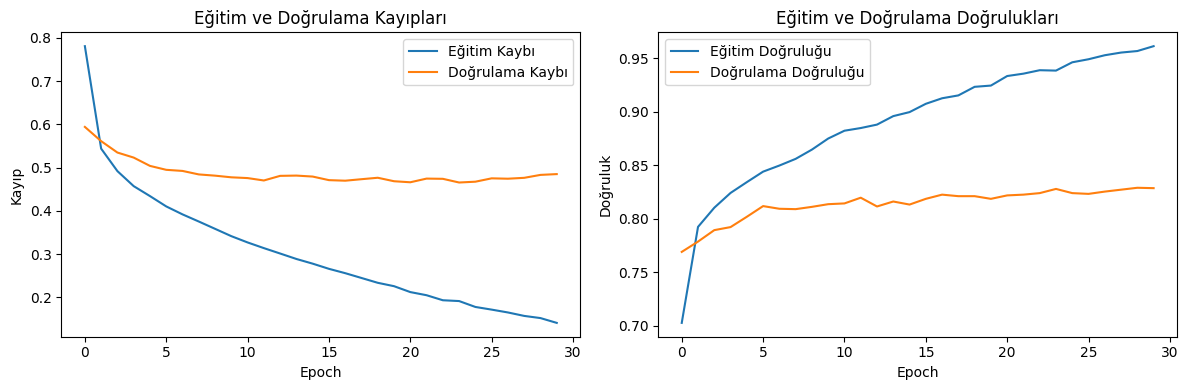

In [ ]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama kayıplarını görselleştirmek
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kayıpları')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğrulukları')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.tight_layout()
plt.show()


88/88 [==============================] - 5s 32ms/step


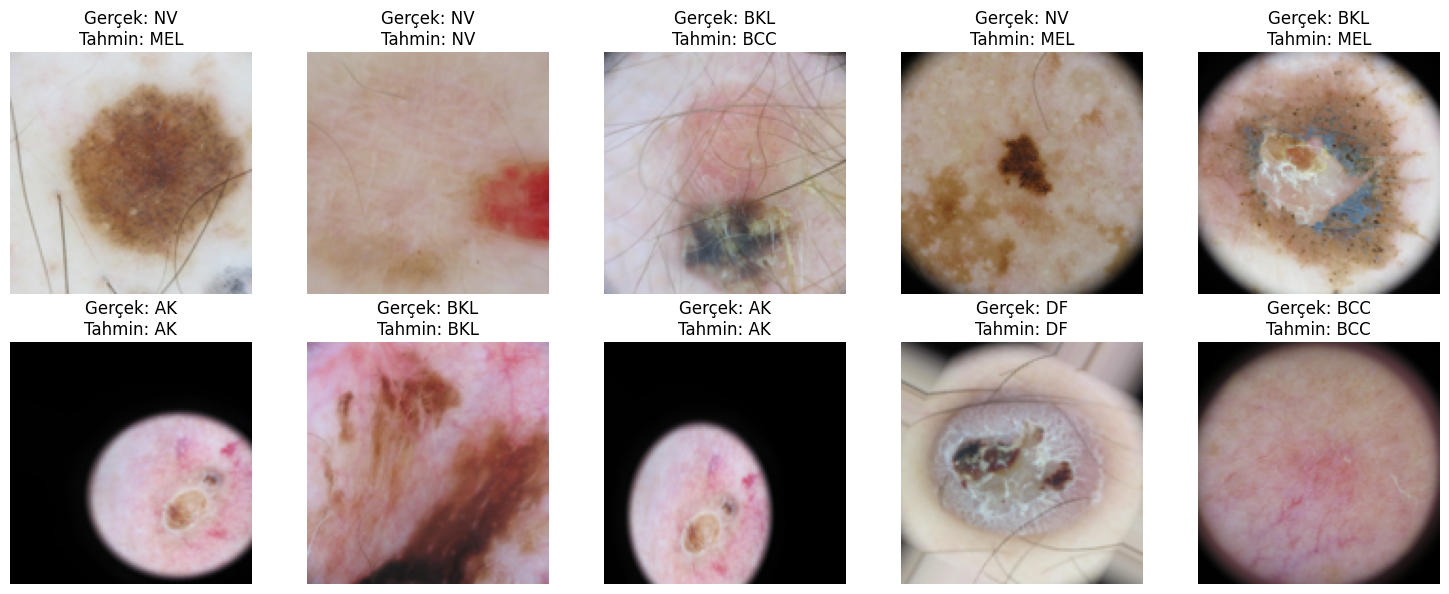

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Test setindeki tahminleri al
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Sınıf isimleri
class_names = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC"]

# Birkaç örnek görselleştir
def plot_images(images, labels, predictions, class_names, num_rows=2, num_cols=5):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i])
            true_label = class_names[labels[i]]
            predicted_label = class_names[predictions[i]]
            ax.set_title(f"Gerçek: {true_label}\nTahmin: {predicted_label}")
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Görselleştirmek için ilk 10 örneği seçelim
num_examples = 10
plot_images(test_images[:num_examples], test_labels[:num_examples], predicted_labels[:num_examples], class_names)


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.applications import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Hyperparameters
image_size = 128
num_channels = 3
batch_size = 32
initial_lr = 1e-4
num_epochs = 30
num_classes = 7
dropout_rate = 0.5  # Increase dropout to prevent overfitting
class_names = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC"]
num_samples_per_class = 2000

# Paths to data
mel_images = MEL
nv_images = NV
bcc_images = BCC
ak_images = AK
bkl_images = BKL
df_images = DF
vasc_images = VASC

def augment_data(image_paths, target_count):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    augmented_images = []
    while len(augmented_images) < target_count:
        for image_path in image_paths:
            img = Image.open(image_path)
            img = img.resize((image_size, image_size))
            img_array = np.expand_dims(np.array(img) / 255.0, 0)
            i = 0
            for batch in datagen.flow(img_array, batch_size=1):
                augmented_images.append(batch[0])
                i += 1
                if len(augmented_images) >= target_count:
                    break
            if len(augmented_images) >= target_count:
                break
    return np.array(augmented_images)

# Augment data for classes "DF", "AK" and "VASC"
target_count = 2000
augmented_DF = augment_data(df_images, target_count)
augmented_AK = augment_data(ak_images, target_count)
augmented_VASC = augment_data(vasc_images, target_count)

# Load and normalize images for other classes
def load_and_normalize_images(image_paths, image_size, num_samples):
    images = []
    for image_path in image_paths[:num_samples]:
        img = Image.open(image_path)
        img = img.resize((image_size, image_size))
        img = np.array(img) / 255.0  # Normalize
        images.append(img)
    return np.array(images)

mel_images = load_and_normalize_images(mel_images, image_size, num_samples_per_class)
nv_images = load_and_normalize_images(nv_images, image_size, num_samples_per_class)
bcc_images = load_and_normalize_images(bcc_images, image_size, num_samples_per_class)
ak_images = augmented_AK[:num_samples_per_class]
bkl_images = load_and_normalize_images(bkl_images, image_size, num_samples_per_class)
df_images = augmented_DF[:num_samples_per_class]
vasc_images = augmented_VASC[:num_samples_per_class]

# Combine all images and labels
all_images = np.concatenate([mel_images, nv_images, bcc_images, ak_images, bkl_images, df_images, vasc_images])
labels = np.concatenate([[label] * num_samples_per_class for label in range(num_classes)])

# Convert labels to integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split the dataset into training and testing
train_images, test_images, train_labels, test_labels = train_test_split(all_images, labels, test_size=0.2, random_state=42)

# Initialize DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model (with initial frozen base model)
history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Unfreeze the base model and retrain with a lower learning rate
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr/10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model again
history_fine = model.fit(train_images, train_labels, epochs=num_epochs//2, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print(f"DenseNet121 Test Accuracy: {test_accuracy}")


Epoch 1/30
350/350 [==============================] - 24s 52ms/step - loss: 0.9541 - accuracy: 0.6576 - val_loss: 0.6159 - val_accuracy: 0.7614 - lr: 1.0000e-04
Epoch 2/30
350/350 [==============================] - 14s 41ms/step - loss: 0.6308 - accuracy: 0.7586 - val_loss: 0.5604 - val_accuracy: 0.7850 - lr: 1.0000e-04
Epoch 3/30
350/350 [==============================] - 15s 41ms/step - loss: 0.5754 - accuracy: 0.7791 - val_loss: 0.5446 - val_accuracy: 0.7911 - lr: 1.0000e-04
Epoch 4/30
350/350 [==============================] - 14s 41ms/step - loss: 0.5320 - accuracy: 0.7917 - val_loss: 0.5262 - val_accuracy: 0.7961 - lr: 1.0000e-04
Epoch 5/30
350/350 [==============================] - 14s 41ms/step - loss: 0.5050 - accuracy: 0.8035 - val_loss: 0.5156 - val_accuracy: 0.8011 - lr: 1.0000e-04
Epoch 6/30
350/350 [==============================] - 14s 41ms/step - loss: 0.4791 - accuracy: 0.8121 - val_loss: 0.5059 - val_accuracy: 0.8046 - lr: 1.0000e-04
Epoch 7/30
350/350 [==============

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Hiperparametreler
image_size = 128
num_channels = 3
batch_size = 32
initial_lr = 1e-4
num_epochs = 30
num_classes = 7
dropout_rate = 0.5
class_names = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC"]
num_samples_per_class = 2000

# Paths to data
mel_images = MEL
nv_images = NV
bcc_images = BCC
ak_images = AK
bkl_images = BKL
df_images = DF
vasc_images = VASC

# Veri artırma fonksiyonu
def augment_data(image_paths, target_count):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    augmented_images = []
    while len(augmented_images) < target_count:
        for image_path in image_paths:
            img = Image.open(image_path)
            img = img.resize((image_size, image_size))
            img_array = np.expand_dims(np.array(img) / 255.0, 0)
            i = 0
            for batch in datagen.flow(img_array, batch_size=1):
                augmented_images.append(batch[0])
                i += 1
                if len(augmented_images) >= target_count:
                    break
            if len(augmented_images) >= target_count:
                break
    return np.array(augmented_images)

# Augment data for classes "DF", "AK" and "VASC"
target_count = 5000
augmented_DF = augment_data(df_images, target_count)
augmented_AK = augment_data(ak_images, target_count)
augmented_VASC = augment_data(vasc_images, target_count)

# Load and normalize images for other classes
def load_and_normalize_images(image_paths, image_size, num_samples):
    images = []
    for image_path in image_paths[:num_samples]:
        img = Image.open(image_path)
        img = img.resize((image_size, image_size))
        img = np.array(img) / 255.0  # Normalize
        images.append(img)
    return np.array(images)

mel_images = load_and_normalize_images(mel_images, image_size, num_samples_per_class)
nv_images = load_and_normalize_images(nv_images, image_size, num_samples_per_class)
bcc_images = load_and_normalize_images(bcc_images, image_size, num_samples_per_class)
ak_images = augmented_AK[:num_samples_per_class]
bkl_images = load_and_normalize_images(bkl_images, image_size, num_samples_per_class)
df_images = augmented_DF[:num_samples_per_class]
vasc_images = augmented_VASC[:num_samples_per_class]

# Combine all images and labels
all_images = np.concatenate([mel_images, nv_images, bcc_images, ak_images, bkl_images, df_images, vasc_images])
labels = np.concatenate([[label] * num_samples_per_class for label in range(num_classes)])

# Convert labels to integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split the dataset into training and testing
train_images, test_images, train_labels, test_labels = train_test_split(all_images, labels, test_size=0.2, random_state=42)

# Initialize DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model (with initial frozen base model)
history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Unfreeze the base model and retrain with a lower learning rate
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr/10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model again
history_fine = model.fit(train_images, train_labels, epochs=num_epochs//2, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print(f"DenseNet121 Test Accuracy: {test_accuracy}")

KeyboardInterrupt: 

132/132 [==============================] - 4s 32ms/step


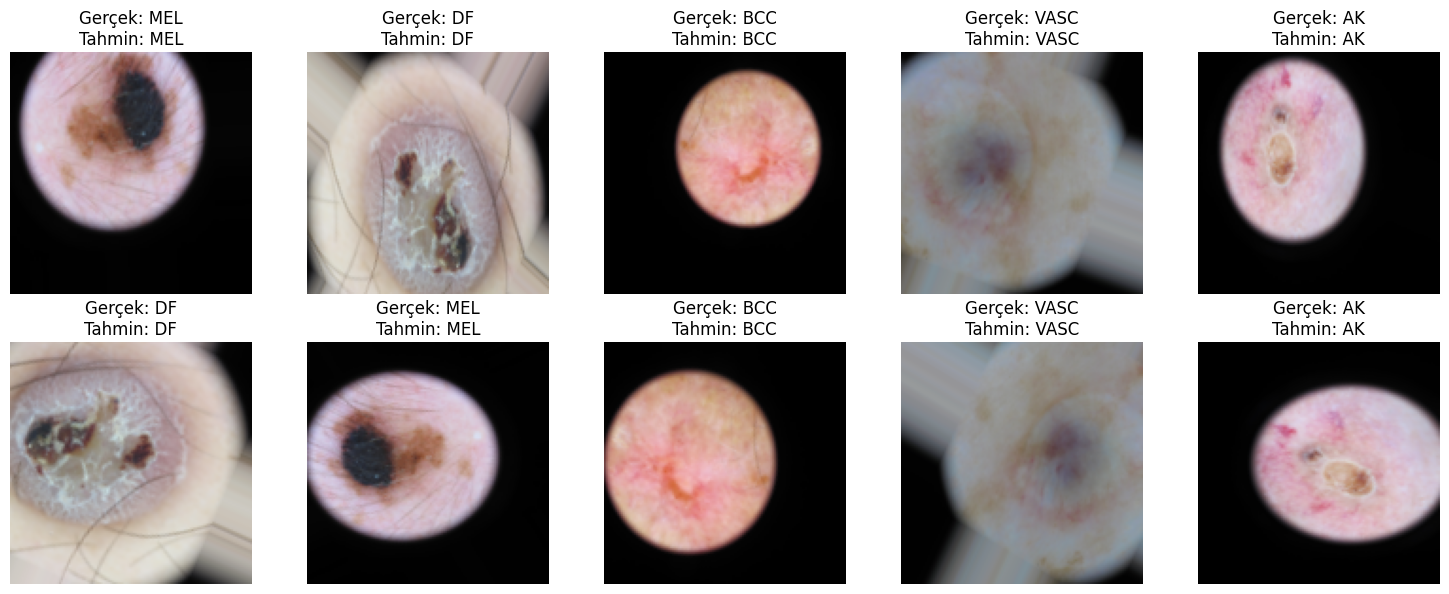

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Test setindeki tahminleri al
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Sınıf isimleri
class_names = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC"]

# Birkaç örnek görselleştir
def plot_images(images, labels, predictions, class_names, num_rows=2, num_cols=5):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i])
            true_label = class_names[labels[i]]
            predicted_label = class_names[predictions[i]]
            ax.set_title(f"Gerçek: {true_label}\nTahmin: {predicted_label}")
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Görselleştirmek için ilk 10 örneği seçelim
num_examples = 10
plot_images(test_images[:num_examples], test_labels[:num_examples], predicted_labels[:num_examples], class_names)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Hiperparametreler
image_size = 128
num_channels = 3
batch_size = 32
initial_lr = 1e-4
num_epochs = 30
num_classes = 7
dropout_rate = 0.5
class_names = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC"]
num_samples_per_class = 2000

# Paths to data
mel_images = MEL
nv_images = NV
bcc_images = BCC
ak_images = AK
bkl_images = BKL
df_images = DF
vasc_images = VASC

# Veri artırma fonksiyonu
def augment_data(image_paths, target_count):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    augmented_images = []
    while len(augmented_images) < target_count:
        for image_path in image_paths:
            img = Image.open(image_path)
            img = img.resize((image_size, image_size))
            img_array = np.expand_dims(np.array(img) / 255.0, 0)
            i = 0
            for batch in datagen.flow(img_array, batch_size=1):
                augmented_images.append(batch[0])
                i += 1
                if len(augmented_images) >= target_count:
                    break
            if len(augmented_images) >= target_count:
                break
    return np.array(augmented_images)


# Augment data for classes "DF", "AK" and "VASC"
target_count = 2000
augmented_DF = augment_data(df_images, target_count)
augmented_AK = augment_data(ak_images, target_count)
augmented_VASC = augment_data(vasc_images, target_count)

# Load and normalize images for other classes
def load_and_normalize_images(image_paths, image_size, num_samples):
    images = []
    for image_path in image_paths[:num_samples]:
        img = Image.open(image_path)
        img = img.resize((image_size, image_size))
        img = np.array(img) / 255.0  # Normalize
        images.append(img)
    return np.array(images)

mel_images = load_and_normalize_images(mel_images, image_size, num_samples_per_class)
nv_images = load_and_normalize_images(nv_images, image_size, num_samples_per_class)
bcc_images = load_and_normalize_images(bcc_images, image_size, num_samples_per_class)
ak_images = augmented_AK[:num_samples_per_class]
bkl_images = load_and_normalize_images(bkl_images, image_size, num_samples_per_class)
df_images = augmented_DF[:num_samples_per_class]
vasc_images = augmented_VASC[:num_samples_per_class]

# Combine all images and labels
all_images = np.concatenate([mel_images, nv_images, bcc_images, ak_images, bkl_images, df_images, vasc_images])
labels = np.concatenate([[label] * num_samples_per_class for label in range(num_classes)])

# Convert labels to integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split the dataset into training and testing
train_images, test_images, train_labels, test_labels = train_test_split(all_images, labels, test_size=0.2, random_state=42)

# Initialize ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model (with initial frozen base model)
history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Unfreeze the base model and retrain with a lower learning rate
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr/10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model again
history_fine = model.fit(train_images, train_labels, epochs=num_epochs//2, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print(f"ResNet50 Test Accuracy: {test_accuracy}")

94765736/94765736 [==============================] - 4s 0us/step
Epoch 1/30
350/350 [==============================] - 25s 50ms/step - loss: 1.3948 - accuracy: 0.5177 - val_loss: 1.7932 - val_accuracy: 0.2864 - lr: 1.0000e-04
Epoch 2/30
350/350 [==============================] - 14s 40ms/step - loss: 1.0672 - accuracy: 0.6518 - val_loss: 1.3179 - val_accuracy: 0.4668 - lr: 1.0000e-04
Epoch 3/30
350/350 [==============================] - 14s 40ms/step - loss: 0.9256 - accuracy: 0.6981 - val_loss: 1.4282 - val_accuracy: 0.5225 - lr: 1.0000e-04
Epoch 4/30
350/350 [==============================] - 14s 40ms/step - loss: 0.8457 - accuracy: 0.7142 - val_loss: 1.6148 - val_accuracy: 0.5471 - lr: 1.0000e-04
Epoch 5/30
350/350 [==============================] - 14s 41ms/step - loss: 0.7975 - accuracy: 0.7300 - val_loss: 1.1898 - val_accuracy: 0.6318 - lr: 1.0000e-04
Epoch 6/30
350/350 [==============================] - 14s 41ms/step - loss: 0.7617 - accuracy: 0.7372 - val_loss: 1.2161 - val_acc

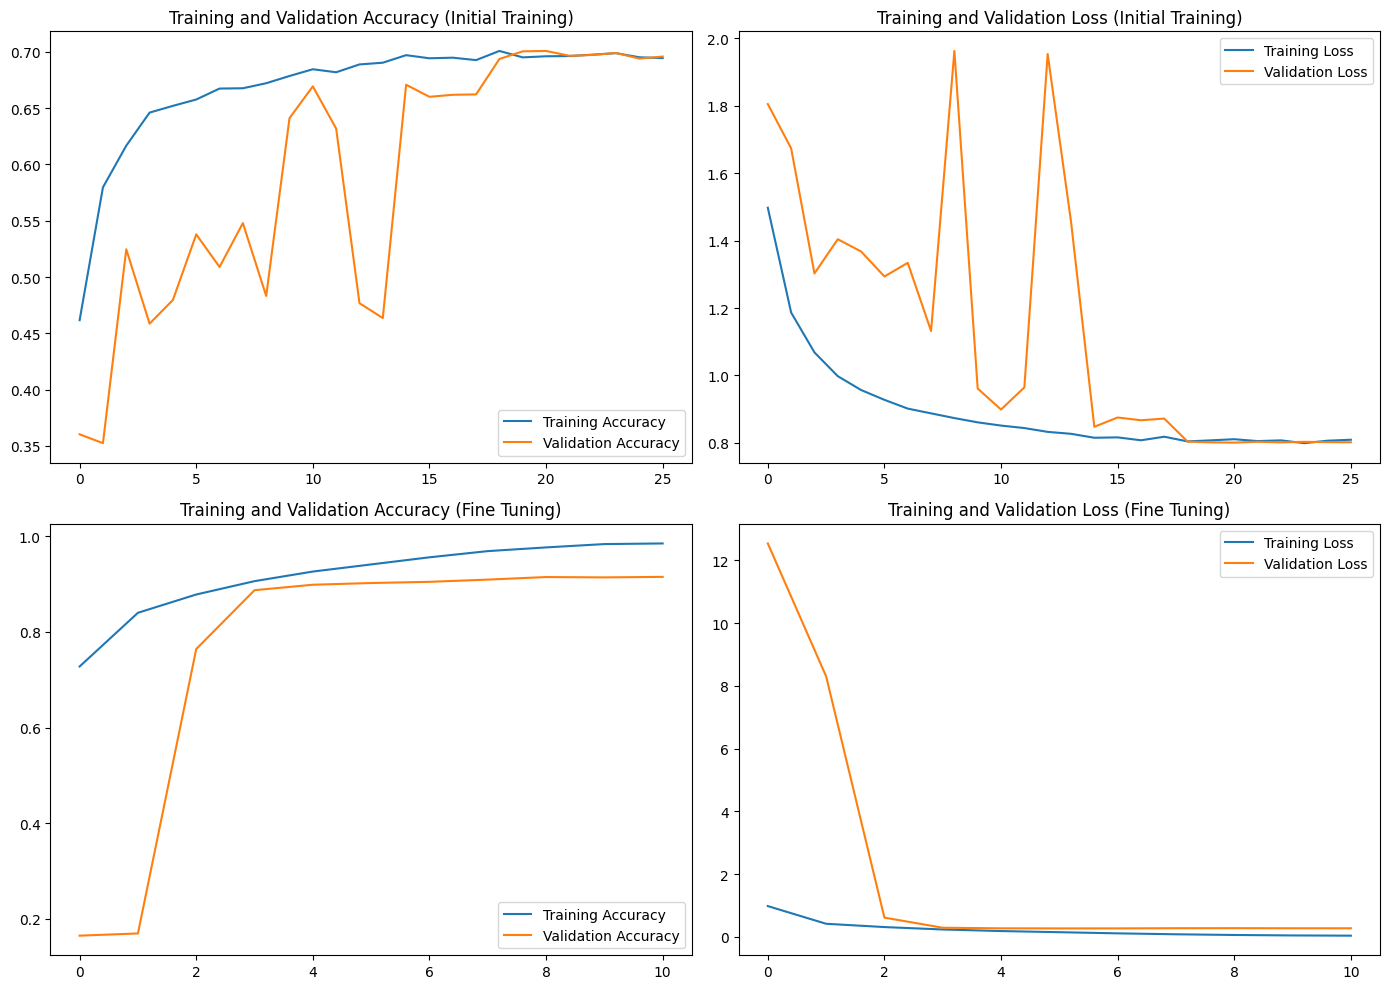

In [ ]:
# Plotting accuracy and loss
def plot_history(history, history_fine):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    acc_fine = history_fine.history['accuracy']
    val_acc_fine = history_fine.history['val_accuracy']
    loss_fine = history_fine.history['loss']
    val_loss_fine = history_fine.history['val_loss']

    epochs_range = range(len(acc))
    epochs_range_fine = range(len(acc_fine))

    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy (Initial Training)')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss (Initial Training)')

    plt.subplot(2, 2, 3)
    plt.plot(epochs_range_fine, acc_fine, label='Training Accuracy')
    plt.plot(epochs_range_fine, val_acc_fine, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy (Fine Tuning)')

    plt.subplot(2, 2, 4)
    plt.plot(epochs_range_fine, loss_fine, label='Training Loss')
    plt.plot(epochs_range_fine, val_loss_fine, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss (Fine Tuning)')

    plt.tight_layout()
    plt.show()

plot_history(history, history_fine)

In [ ]:
# Save the model
model_save_path = '/content/drive/MyDrive/ResNet50_model.h5'
model.save(model_save_path)

# Save the training history
history_df = pd.DataFrame(history.history)
history_df_fine = pd.DataFrame(history_fine.history)
history_save_path = '/content/drive/MyDrive/ResNet50_history.csv'
history_df.to_csv(history_save_path, index=False)
history_save_path_fine = '/content/drive/MyDrive/ResNet50_history_fine.csv'
history_df_fine.to_csv(history_save_path_fine, index=False)

print(f"Model and history saved to {model_save_path} and {history_save_path}")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model and history saved to /content/drive/MyDrive/ResNet50_model.h5 and /content/drive/MyDrive/ResNet50_history.csv


In [ ]:
import numpy as np

# Test seti üzerindeki tahminleri alın
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Gerçek etiketleri alın
true_labels = test_labels

# Tahmin edilen ve gerçek etiketleri karşılaştırarak yazdırın
for i in range(len(true_labels)):
    print(f"Gerçek etiket: {class_names[true_labels[i]]} - Tahmin edilen etiket: {class_names[predicted_labels[i]]}")

# İsterseniz, karşılaştırmayı bir DataFrame içinde de yapabilirsiniz
import pandas as pd

results = pd.DataFrame({
    'Gerçek Etiket': [class_names[label] for label in true_labels],
    'Tahmin Edilen Etiket': [class_names[label] for label in predicted_labels]
})

print(results)

88/88 [==============================] - 4s 33ms/step
Gerçek etiket: NV - Tahmin edilen etiket: NV
Gerçek etiket: NV - Tahmin edilen etiket: NV
Gerçek etiket: BKL - Tahmin edilen etiket: BKL
Gerçek etiket: NV - Tahmin edilen etiket: NV
Gerçek etiket: BKL - Tahmin edilen etiket: BKL
Gerçek etiket: AK - Tahmin edilen etiket: AK
Gerçek etiket: BKL - Tahmin edilen etiket: BKL
Gerçek etiket: AK - Tahmin edilen etiket: AK
Gerçek etiket: DF - Tahmin edilen etiket: DF
Gerçek etiket: BCC - Tahmin edilen etiket: BCC
Gerçek etiket: VASC - Tahmin edilen etiket: VASC
Gerçek etiket: BCC - Tahmin edilen etiket: BCC
Gerçek etiket: DF - Tahmin edilen etiket: DF
Gerçek etiket: BCC - Tahmin edilen etiket: BCC
Gerçek etiket: BCC - Tahmin edilen etiket: BCC
Gerçek etiket: DF - Tahmin edilen etiket: DF
Gerçek etiket: VASC - Tahmin edilen etiket: VASC
Gerçek etiket: BCC - Tahmin edilen etiket: BCC
Gerçek etiket: MEL - Tahmin edilen etiket: BCC
Gerçek etiket: NV - Tahmin edilen etiket: NV
Gerçek etiket: AK - 

88/88 [==============================] - 3s 34ms/step


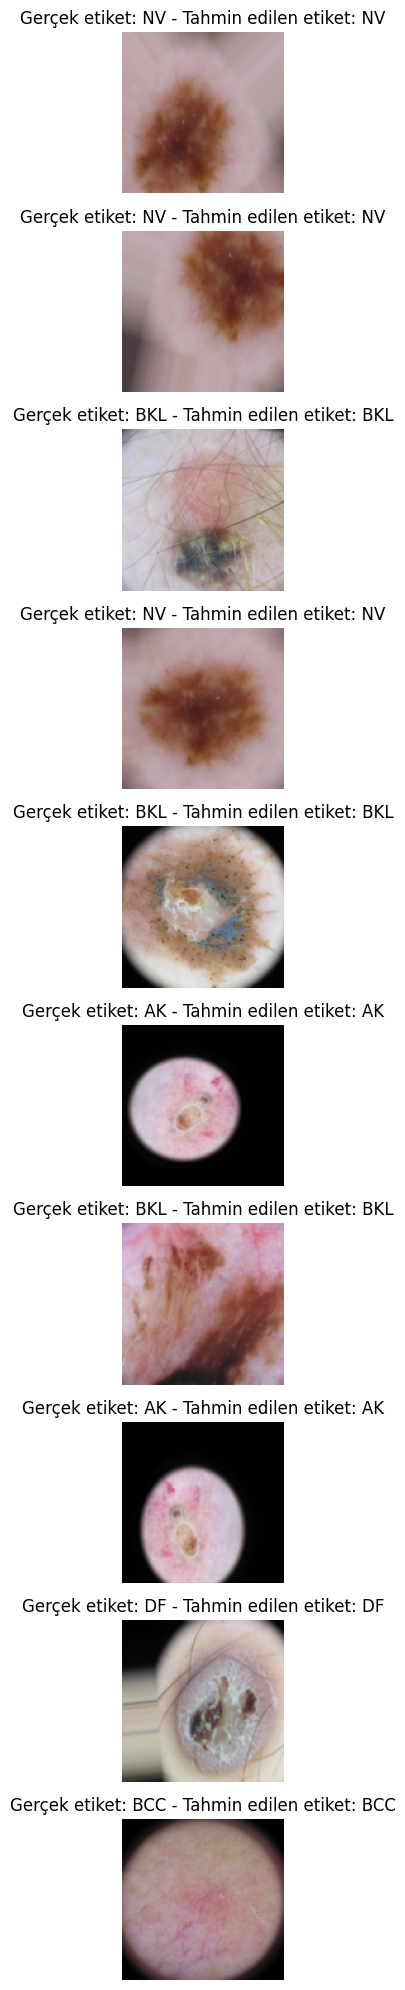

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Test seti üzerindeki tahminleri alın
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Gerçek etiketleri alın
true_labels = test_labels

# Görselleştirme
num_images_to_show = 10
plt.figure(figsize=(20, num_images_to_show * 2))

for i in range(num_images_to_show):
    plt.subplot(num_images_to_show, 1, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"Gerçek etiket: {class_names[true_labels[i]]} - Tahmin edilen etiket: {class_names[predicted_labels[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
pip install matplotlib


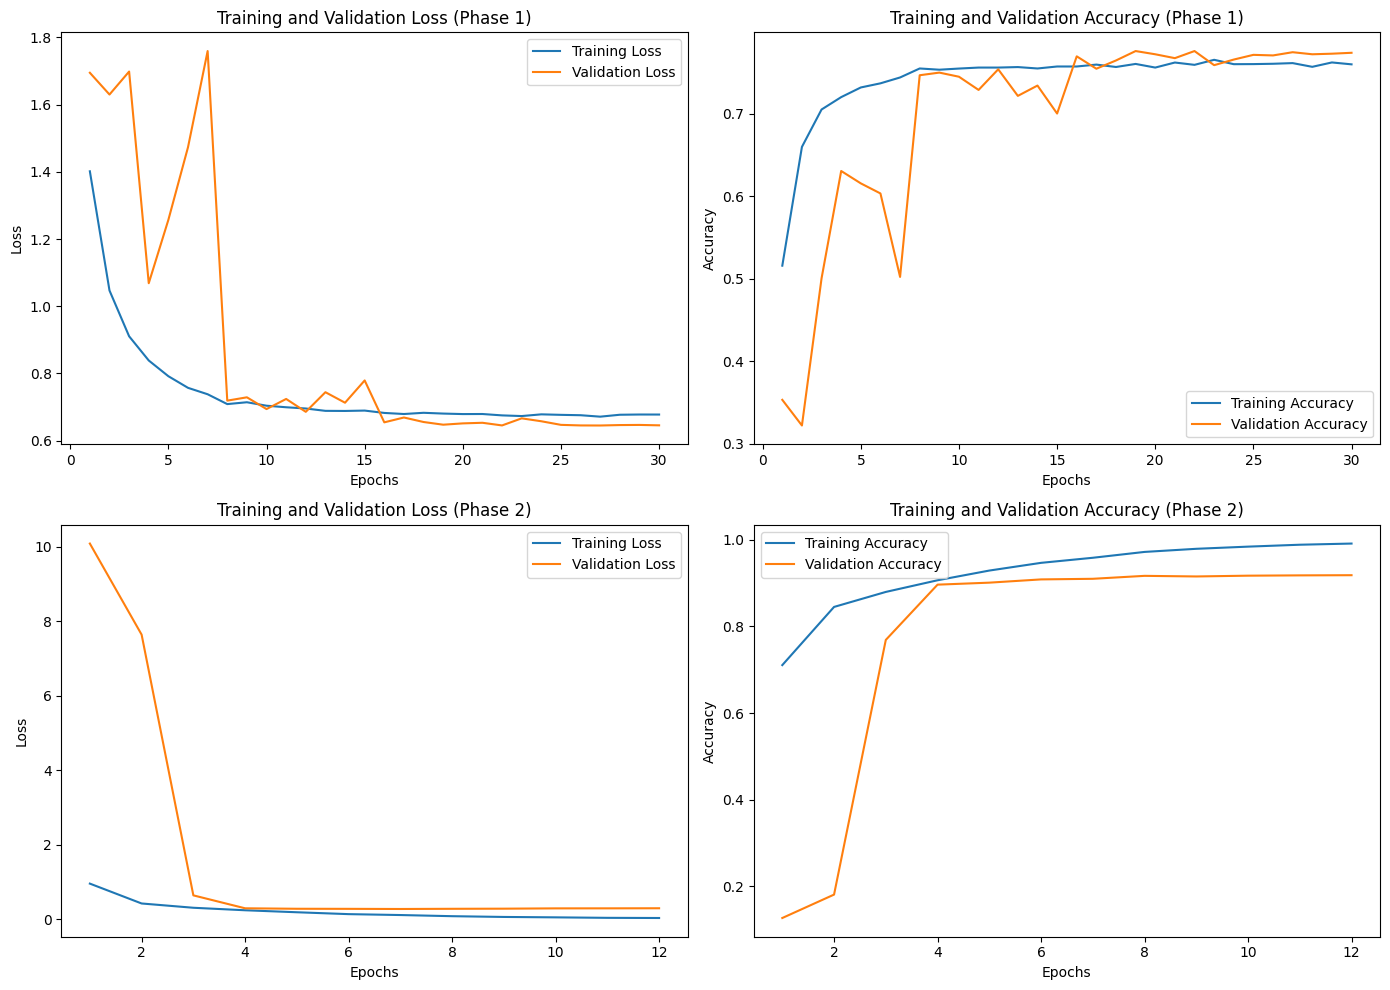

In [ ]:
import matplotlib.pyplot as plt

# Data from the epochs
epochs_1 = list(range(1, 31))
train_loss_1 = [1.4017, 1.0469, 0.9106, 0.8386, 0.7918, 0.7572, 0.7381, 0.7088, 0.7143, 0.7040, 0.6994, 0.6957, 0.6887, 0.6884, 0.6895, 0.6825, 0.6793, 0.6829, 0.6806, 0.6791, 0.6793, 0.6752, 0.6732, 0.6783, 0.6768, 0.6757, 0.6714, 0.6771, 0.6778, 0.6777]
val_loss_1 = [1.6950, 1.6302, 1.6986, 1.0686, 1.2573, 1.4734, 1.7596, 0.7191, 0.7290, 0.6940, 0.7241, 0.6858, 0.7442, 0.7129, 0.7792, 0.6545, 0.6689, 0.6555, 0.6475, 0.6514, 0.6532, 0.6453, 0.6664, 0.6577, 0.6470, 0.6453, 0.6451, 0.6464, 0.6468, 0.6456]
train_acc_1 = [0.5157, 0.6596, 0.7049, 0.7199, 0.7316, 0.7366, 0.7437, 0.7546, 0.7531, 0.7545, 0.7557, 0.7557, 0.7563, 0.7546, 0.7570, 0.7570, 0.7593, 0.7564, 0.7601, 0.7557, 0.7618, 0.7590, 0.7651, 0.7598, 0.7599, 0.7603, 0.7611, 0.7566, 0.7619, 0.7596]
val_acc_1 = [0.3532, 0.3221, 0.5004, 0.6304, 0.6154, 0.6032, 0.5021, 0.7464, 0.7496, 0.7446, 0.7286, 0.7536, 0.7214, 0.7339, 0.7000, 0.7693, 0.7543, 0.7643, 0.7757, 0.7718, 0.7671, 0.7757, 0.7586, 0.7654, 0.7711, 0.7704, 0.7743, 0.7718, 0.7725, 0.7736]

epochs_2 = list(range(1, 13))
train_loss_2 = [0.9542, 0.4205, 0.3055, 0.2383, 0.1848, 0.1342, 0.1101, 0.0791, 0.0588, 0.0478, 0.0349, 0.0305]
val_loss_2 = [10.0884, 7.6421, 0.6385, 0.2911, 0.2785, 0.2764, 0.2726, 0.2775, 0.2809, 0.2890, 0.2898, 0.2922]
train_acc_2 = [0.7105, 0.8447, 0.8793, 0.9062, 0.9286, 0.9464, 0.9581, 0.9716, 0.9788, 0.9838, 0.9882, 0.9909]
val_acc_2 = [0.1271, 0.1811, 0.7686, 0.8961, 0.9007, 0.9082, 0.9096, 0.9164, 0.9150, 0.9168, 0.9175, 0.9179]

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Training and validation loss for the first training phase
axs[0, 0].plot(epochs_1, train_loss_1, label='Training Loss')
axs[0, 0].plot(epochs_1, val_loss_1, label='Validation Loss')
axs[0, 0].set_title('Training and Validation Loss (Phase 1)')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

# Training and validation accuracy for the first training phase
axs[0, 1].plot(epochs_1, train_acc_1, label='Training Accuracy')
axs[0, 1].plot(epochs_1, val_acc_1, label='Validation Accuracy')
axs[0, 1].set_title('Training and Validation Accuracy (Phase 1)')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()

# Training and validation loss for the second training phase
axs[1, 0].plot(epochs_2, train_loss_2, label='Training Loss')
axs[1, 0].plot(epochs_2, val_loss_2, label='Validation Loss')
axs[1, 0].set_title('Training and Validation Loss (Phase 2)')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()

# Training and validation accuracy for the second training phase
axs[1, 1].plot(epochs_2, train_acc_2, label='Training Accuracy')
axs[1, 1].plot(epochs_2, val_acc_2, label='Validation Accuracy')
axs[1, 1].set_title('Training and Validation Accuracy (Phase 2)')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3, Xception, NASNetMobile, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image

# Hyperparameters
image_size = 128
num_channels = 3
batch_size = 32
initial_lr = 1e-4
num_epochs = 30
num_classes = 7
dropout_rate = 0.5
class_names = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC"]
num_samples_per_class = 2000

# Paths to data
mel_images = MEL
nv_images = NV
bcc_images = BCC
ak_images = AK
bkl_images = BKL
df_images = DF
vasc_images = VASC

# Data augmentation function
def augment_data(image_paths, target_count):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    augmented_images = []
    while len(augmented_images) < target_count:
        for image_path in image_paths:
            img = Image.open(image_path)
            img = img.resize((image_size, image_size))
            img_array = np.expand_dims(np.array(img) / 255.0, 0)
            for batch in datagen.flow(img_array, batch_size=1):
                augmented_images.append(batch[0])
                if len(augmented_images) >= target_count:
                    break
            if len(augmented_images) >= target_count:
                break
    return np.array(augmented_images)

# Augment data for classes "DF", "AK" and "VASC"
target_count = 2000
augmented_DF = augment_data(df_images, target_count)
augmented_AK = augment_data(ak_images, target_count)
augmented_VASC = augment_data(vasc_images, target_count)

# Load and normalize images for other classes
def load_and_normalize_images(image_paths, image_size, num_samples):
    images = []
    for image_path in image_paths[:num_samples]:
        img = Image.open(image_path)
        img = img.resize((image_size, image_size))
        img = np.array(img) / 255.0  # Normalize
        images.append(img)
    return np.array(images)

mel_images = load_and_normalize_images(mel_images, image_size, num_samples_per_class)
nv_images = load_and_normalize_images(nv_images, image_size, num_samples_per_class)
bcc_images = load_and_normalize_images(bcc_images, image_size, num_samples_per_class)
ak_images = augmented_AK[:num_samples_per_class]
bkl_images = load_and_normalize_images(bkl_images, image_size, num_samples_per_class)
df_images = augmented_DF[:num_samples_per_class]
vasc_images = augmented_VASC[:num_samples_per_class]

# Combine all images and labels
all_images = np.concatenate([mel_images, nv_images, bcc_images, ak_images, bkl_images, df_images, vasc_images])
labels = np.concatenate([[label] * num_samples_per_class for label in range(num_classes)])

# Convert labels to integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split the dataset into training and testing
train_images, test_images, train_labels, test_labels = train_test_split(all_images, labels, test_size=0.2, random_state=42)

# Define models
base_models = [
    ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels)),
    VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels)),
    InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels)),
    Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels)),
    NASNetMobile(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels)),
    MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
]

# Function to create and compile model
def create_model(base_model):
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

best_accuracy = 0
best_model_name = ""
results = []

# Train and evaluate each model
for base_model in base_models:
    model = create_model(base_model)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

    history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

    base_model.trainable = True
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr/10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history_fine = model.fit(train_images, train_labels, epochs=num_epochs//2, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

    test_loss, test_accuracy = model.evaluate(test_images, test_labels)
    model_name = base_model.name.split('/')[-1]
    results.append((model_name, test_accuracy))

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model_name = model_name

# Print results
for result in results:
    print(f"Model: {result[0]}, Test Accuracy: {result[1]}")

print(f"Best Model: {best_model_name}, Best Test Accuracy: {best_accuracy}")



9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/30
350/350 [==============================] - 26s 50ms/step - loss: 1.5389 - accuracy: 0.4521 - val_loss: 1.8174 - val_accuracy: 0.2914 - lr: 1.0000e-04
Epoch 2/30
350/350 [==============================] - 14s 41ms/step - loss: 1.2010 - accuracy: 0.5834 - val_loss: 1.7538 - val_accuracy: 0.4407 - lr: 1.0000e-04
Epoch 3/30
350/350 [==============================] - 14s 41ms/step - loss: 1.0693 - accuracy: 0.6203 - val_loss: 1.3619 - val_accuracy: 0.4400 - lr: 1.0000e-04
Epoch 4/30
350/350 [==============================] - 15s 42ms/step - loss: 0.9981 - accuracy: 0.6435 - val_loss: 1.4153 - val_accuracy: 0.5904 - lr: 1.0000e-04
Epoch 5/30
350/350 [==============================] - 15s 42ms/step - loss: 0.9515 - accuracy: 0.6597 - val_loss: 1.5230 - val_accuracy: 0.5386 - lr: 1.0000e-04
Epoch 6/30
350/350 [==============================] - 15s 43ms/step - loss: 0.9202 - accuracy: 0.6653 - val_loss: 0.9425 - val_accur

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from PIL import Image

# Hiperparametreler
image_size = 128
num_channels = 3
batch_size = 32
initial_lr = 1e-4
num_epochs = 30
num_classes = 7
dropout_rate = 0.5
class_names = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC"]
num_samples_per_class = 2000

# Paths to data
mel_images = MEL
nv_images = NV
bcc_images = BCC
ak_images = AK
bkl_images = BKL
df_images = DF
vasc_images = VASC

# Veri artırma fonksiyonu
def augment_data(image_paths, target_count):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    augmented_images = []
    while len(augmented_images) < target_count:
        for image_path in image_paths:
            img = Image.open(image_path)
            img = img.resize((image_size, image_size))
            img_array = np.expand_dims(np.array(img) / 255.0, 0)
            i = 0
            for batch in datagen.flow(img_array, batch_size=1):
                augmented_images.append(batch[0])
                i += 1
                if len(augmented_images) >= target_count:
                    break
            if len(augmented_images) >= target_count:
                break
    return np.array(augmented_images)

# Augment data for classes "DF", "AK" and "VASC"
target_count = 2000
augmented_DF = augment_data(df_images, target_count)
augmented_AK = augment_data(ak_images, target_count)
augmented_VASC = augment_data(vasc_images, target_count)

# Load and normalize images for other classes
def load_and_normalize_images(image_paths, image_size, num_samples):
    images = []
    for image_path in image_paths[:num_samples]:
        img = Image.open(image_path)
        img = img.resize((image_size, image_size))
        img = np.array(img) / 255.0  # Normalize
        images.append(img)
    return np.array(images)

mel_images = load_and_normalize_images(mel_images, image_size, num_samples_per_class)
nv_images = load_and_normalize_images(nv_images, image_size, num_samples_per_class)
bcc_images = load_and_normalize_images(bcc_images, image_size, num_samples_per_class)
ak_images = augmented_AK[:num_samples_per_class]
bkl_images = load_and_normalize_images(bkl_images, image_size, num_samples_per_class)
df_images = augmented_DF[:num_samples_per_class]
vasc_images = augmented_VASC[:num_samples_per_class]

# Combine all images and labels
all_images = np.concatenate([mel_images, nv_images, bcc_images, ak_images, bkl_images, df_images, vasc_images])
labels = np.concatenate([[label] * num_samples_per_class for label in range(num_classes)])

# Convert labels to integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split the dataset into training and testing
train_images, test_images, train_labels, test_labels = train_test_split(all_images, labels, test_size=0.2, random_state=42)

# Initialize VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model (with initial frozen base model)
history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Unfreeze the base model and retrain with a lower learning rate
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=initial_lr/10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model again
history_fine = model.fit(train_images, train_labels, epochs=num_epochs//2, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print(f"VGG16 Test Accuracy: {test_accuracy}")


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/30
350/350 [==============================] - 27s 57ms/step - loss: 1.1131 - accuracy: 0.6168 - val_loss: 0.9310 - val_accuracy: 0.7043 - lr: 1.0000e-04
Epoch 2/30
350/350 [==============================] - 17s 48ms/step - loss: 0.8171 - accuracy: 0.7039 - val_loss: 0.6695 - val_accuracy: 0.7439 - lr: 1.0000e-04
Epoch 3/30
350/350 [==============================] - 17s 49ms/step - loss: 0.7395 - accuracy: 0.7242 - val_loss: 0.6423 - val_accuracy: 0.7582 - lr: 1.0000e-04
Epoch 4/30
350/350 [==============================] - 18s 51ms/step - loss: 0.7022 - accuracy: 0.7329 - val_loss: 0.6256 - val_accuracy: 0.7589 - lr: 1.0000e-04
Epoch 5/30
350/350 [==============================] - 18s 51ms/step - loss: 0.6697 - accuracy: 0.7403 - val_loss: 0.6031 - val_accuracy: 0.7625 - lr: 1.0000e-04
Epoch 6/30
350/350 [==============================] - 18s 51ms/step - loss: 0.6332 - accuracy: 0.7509 - val_loss: 0.5919 - val_acc

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Hiperparametreler
image_size = 128
num_channels = 3
batch_size = 32
initial_lr = 1e-4
num_epochs = 30
num_classes = 7
dropout_rate = 0.5

# Initialize InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model (with initial frozen base model)
history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Unfreeze the base model and retrain with a lower learning rate
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=initial_lr/10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model again
history_fine = model.fit(train_images, train_labels, epochs=num_epochs//2, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print(f"InceptionV3 Test Accuracy: {test_accuracy}")


87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/30
350/350 [==============================] - 22s 44ms/step - loss: 1.0866 - accuracy: 0.6560 - val_loss: 0.7743 - val_accuracy: 0.7211 - lr: 1.0000e-04
Epoch 2/30
350/350 [==============================] - 11s 32ms/step - loss: 0.7618 - accuracy: 0.7353 - val_loss: 0.7050 - val_accuracy: 0.7461 - lr: 1.0000e-04
Epoch 3/30
350/350 [==============================] - 11s 32ms/step - loss: 0.6709 - accuracy: 0.7548 - val_loss: 0.6683 - val_accuracy: 0.7471 - lr: 1.0000e-04
Epoch 4/30
350/350 [==============================] - 11s 31ms/step - loss: 0.6034 - accuracy: 0.7726 - val_loss: 0.6581 - val_accuracy: 0.7479 - lr: 1.0000e-04
Epoch 5/30
350/350 [==============================] - 11s 31ms/step - loss: 0.5685 - accuracy: 0.7821 - val_loss: 0.6432 - val_accuracy: 0.7471 - lr: 1.0000e-04
Epoch 6/30
350/350 [==============================] - 11s 31ms/step - loss: 0.5248 - accuracy: 0.7952 - val_loss: 0.6460 - val_acc

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Hiperparametreler
image_size = 128
num_channels = 3
batch_size = 32
initial_lr = 1e-4
num_epochs = 30
num_classes = 7
dropout_rate = 0.5

# Initialize Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model (with initial frozen base model)
history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Unfreeze the base model and retrain with a lower learning rate
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=initial_lr/10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model again
history_fine = model.fit(train_images, train_labels, epochs=num_epochs//2, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print(f"Xception Test Accuracy: {test_accuracy}")


83683744/83683744 [==============================] - 1s 0us/step
Epoch 1/30
350/350 [==============================] - 26s 63ms/step - loss: 1.0290 - accuracy: 0.6612 - val_loss: 0.6588 - val_accuracy: 0.7364 - lr: 1.0000e-04
Epoch 2/30
350/350 [==============================] - 18s 53ms/step - loss: 0.7381 - accuracy: 0.7323 - val_loss: 0.6172 - val_accuracy: 0.7614 - lr: 1.0000e-04
Epoch 3/30
350/350 [==============================] - 18s 52ms/step - loss: 0.6282 - accuracy: 0.7636 - val_loss: 0.6137 - val_accuracy: 0.7607 - lr: 1.0000e-04
Epoch 4/30
350/350 [==============================] - 18s 52ms/step - loss: 0.5542 - accuracy: 0.7870 - val_loss: 0.5947 - val_accuracy: 0.7746 - lr: 1.0000e-04
Epoch 5/30
350/350 [==============================] - 18s 52ms/step - loss: 0.5075 - accuracy: 0.8045 - val_loss: 0.5601 - val_accuracy: 0.7746 - lr: 1.0000e-04
Epoch 6/30
350/350 [==============================] - 18s 53ms/step - loss: 0.4612 - accuracy: 0.8263 - val_loss: 0.5556 - val_acc

In [ ]:
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Hiperparametreler
image_size = 128
num_channels = 3
batch_size = 32
initial_lr = 1e-4
num_epochs = 30
num_classes = 7
dropout_rate = 0.5

# Initialize NASNetMobile model
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model (with initial frozen base model)
history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Unfreeze the base model and retrain with a lower learning rate
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=initial_lr/10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model again
history_fine = model.fit(train_images, train_labels, epochs=num_epochs//2, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print(f"NASNetMobile Test Accuracy: {test_accuracy}")


19993432/19993432 [==============================] - 0s 0us/step
Epoch 1/30
350/350 [==============================] - 30s 52ms/step - loss: 1.1695 - accuracy: 0.6246 - val_loss: 0.7175 - val_accuracy: 0.7257 - lr: 1.0000e-04
Epoch 2/30
350/350 [==============================] - 12s 35ms/step - loss: 0.8037 - accuracy: 0.7154 - val_loss: 0.6747 - val_accuracy: 0.7454 - lr: 1.0000e-04
Epoch 3/30
350/350 [==============================] - 12s 35ms/step - loss: 0.6951 - accuracy: 0.7432 - val_loss: 0.6340 - val_accuracy: 0.7539 - lr: 1.0000e-04
Epoch 4/30
350/350 [==============================] - 12s 35ms/step - loss: 0.6263 - accuracy: 0.7622 - val_loss: 0.6255 - val_accuracy: 0.7607 - lr: 1.0000e-04
Epoch 5/30
350/350 [==============================] - 12s 35ms/step - loss: 0.5841 - accuracy: 0.7794 - val_loss: 0.6167 - val_accuracy: 0.7654 - lr: 1.0000e-04
Epoch 6/30
350/350 [==============================] - 12s 35ms/step - loss: 0.5445 - accuracy: 0.7869 - val_loss: 0.6125 - val_acc

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Hiperparametreler
image_size = 128
num_channels = 3
batch_size = 32
initial_lr = 1e-4
num_epochs = 30
num_classes = 7
dropout_rate = 0.5

# Initialize MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model (with initial frozen base model)
history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Unfreeze the base model and retrain with a lower learning rate
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=initial_lr/10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model again
history_fine = model.fit(train_images, train_labels, epochs=num_epochs//2, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print(f"MobileNetV2 Test Accuracy: {test_accuracy}")


9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/30
350/350 [==============================] - 13s 27ms/step - loss: 1.0438 - accuracy: 0.6700 - val_loss: 0.6470 - val_accuracy: 0.7529 - lr: 1.0000e-04
Epoch 2/30
350/350 [==============================] - 6s 18ms/step - loss: 0.7379 - accuracy: 0.7486 - val_loss: 0.6191 - val_accuracy: 0.7714 - lr: 1.0000e-04
Epoch 3/30
350/350 [==============================] - 6s 19ms/step - loss: 0.6162 - accuracy: 0.7799 - val_loss: 0.5947 - val_accuracy: 0.7746 - lr: 1.0000e-04
Epoch 4/30
350/350 [==============================] - 7s 19ms/step - loss: 0.5597 - accuracy: 0.7884 - val_loss: 0.5734 - val_accuracy: 0.7754 - lr: 1.0000e-04
Epoch 5/30
350/350 [==============================] - 7s 19ms/step - loss: 0.5272 - accuracy: 0.8012 - val_loss: 0.5598 - val_accuracy: 0.7825 - lr: 1.0000e-04
Epoch 6/30
350/350 [==============================] - 6s 18ms/step - loss: 0.4916 - accuracy: 0.8106 - val_loss: 0.5475 - val_accuracy: 

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Hiperparametreler
image_size = 128
num_channels = 3
batch_size = 32
initial_lr = 1e-4
num_epochs = 30
num_classes = 7
dropout_rate = 0.5
class_names = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC"]
num_samples_per_class = 2000

# Paths to data
mel_images = MEL
nv_images = NV
bcc_images = BCC
ak_images = AK
bkl_images = BKL
df_images = DF
vasc_images = VASC

# Veri artırma fonksiyonu
def augment_data(image_paths, target_count):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    augmented_images = []
    while len(augmented_images) < target_count:
        for image_path in image_paths:
            img = Image.open(image_path)
            img = img.resize((image_size, image_size))
            img_array = np.expand_dims(np.array(img) / 255.0, 0)
            i = 0
            for batch in datagen.flow(img_array, batch_size=1):
                augmented_images.append(batch[0])
                i += 1
                if len(augmented_images) >= target_count:
                    break
            if len(augmented_images) >= target_count:
                break
    return np.array(augmented_images)


# Augment data for classes "DF", "AK" and "VASC"
target_count = 2000
augmented_DF = augment_data(df_images, target_count)
augmented_AK = augment_data(ak_images, target_count)
augmented_VASC = augment_data(vasc_images, target_count)

# Load and normalize images for other classes
def load_and_normalize_images(image_paths, image_size, num_samples):
    images = []
    for image_path in image_paths[:num_samples]:
        img = Image.open(image_path)
        img = img.resize((image_size, image_size))
        img = np.array(img) / 255.0  # Normalize
        images.append(img)
    return np.array(images)

mel_images = load_and_normalize_images(mel_images, image_size, num_samples_per_class)
nv_images = load_and_normalize_images(nv_images, image_size, num_samples_per_class)
bcc_images = load_and_normalize_images(bcc_images, image_size, num_samples_per_class)
ak_images = augmented_AK[:num_samples_per_class]
bkl_images = load_and_normalize_images(bkl_images, image_size, num_samples_per_class)
df_images = augmented_DF[:num_samples_per_class]
vasc_images = augmented_VASC[:num_samples_per_class]

# Combine all images and labels
all_images = np.concatenate([mel_images, nv_images, bcc_images, ak_images, bkl_images, df_images, vasc_images])
labels = np.concatenate([[label] * num_samples_per_class for label in range(num_classes)])

# Convert labels to integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split the dataset into training and testing
train_images, test_images, train_labels, test_labels = train_test_split(all_images, labels, test_size=0.2, random_state=42)

# Initialize ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model (with initial frozen base model)
history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Unfreeze the base model and retrain with a lower learning rate
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr/10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model again
history_fine = model.fit(train_images, train_labels, epochs=num_epochs//2, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print(f"ResNet50 Test Accuracy: {test_accuracy}")

Epoch 1/30
350/350 [==============================] - 26s 50ms/step - loss: 1.4801 - accuracy: 0.4678 - val_loss: 1.7588 - val_accuracy: 0.3411 - lr: 1.0000e-04
Epoch 2/30
350/350 [==============================] - 14s 40ms/step - loss: 1.1731 - accuracy: 0.5877 - val_loss: 1.2122 - val_accuracy: 0.5604 - lr: 1.0000e-04
Epoch 3/30
350/350 [==============================] - 14s 40ms/step - loss: 1.0571 - accuracy: 0.6246 - val_loss: 1.7186 - val_accuracy: 0.4496 - lr: 1.0000e-04
Epoch 4/30
350/350 [==============================] - 14s 40ms/step - loss: 0.9838 - accuracy: 0.6462 - val_loss: 1.6313 - val_accuracy: 0.3932 - lr: 1.0000e-04
Epoch 5/30
350/350 [==============================] - 14s 41ms/step - loss: 0.9490 - accuracy: 0.6587 - val_loss: 1.1719 - val_accuracy: 0.5532 - lr: 1.0000e-04
Epoch 6/30
350/350 [==============================] - 15s 42ms/step - loss: 0.9177 - accuracy: 0.6653 - val_loss: 1.1049 - val_accuracy: 0.5725 - lr: 1.0000e-04
Epoch 7/30
350/350 [==============

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Hiperparametreler
image_size = 128
num_channels = 3
batch_size = 32
initial_lr = 1e-4
num_epochs = 30
num_classes = 7
dropout_rate = 0.5
class_names = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC"]
num_samples_per_class = 2000

# Paths to data
mel_images = MEL
nv_images = NV
bcc_images = BCC
ak_images = AK
bkl_images = BKL
df_images = DF
vasc_images = VASC

# Veri artırma fonksiyonu
def augment_data(image_paths, target_count):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    augmented_images = []
    while len(augmented_images) < target_count:
        for image_path in image_paths:
            img = Image.open(image_path)
            img = img.resize((image_size, image_size))
            img_array = np.expand_dims(np.array(img) / 255.0, 0)
            i = 0
            for batch in datagen.flow(img_array, batch_size=1):
                augmented_images.append(batch[0])
                i += 1
                if len(augmented_images) >= target_count:
                    break
            if len(augmented_images) >= target_count:
                break
    return np.array(augmented_images)

# Augment data for classes "NV"
target_count_nv = 5000
augmented_NV = augment_data(nv_images, target_count_nv)

# Augment data for classes "DF", "AK" and "VASC"
target_count = 2000
augmented_DF = augment_data(df_images, target_count)
augmented_AK = augment_data(ak_images, target_count)
augmented_VASC = augment_data(vasc_images, target_count)

# Load and normalize images for other classes
def load_and_normalize_images(image_paths, image_size, num_samples):
    images = []
    for image_path in image_paths[:num_samples]:
        img = Image.open(image_path)
        img = img.resize((image_size, image_size))
        img = np.array(img) / 255.0  # Normalize
        images.append(img)
    return np.array(images)

mel_images = load_and_normalize_images(mel_images, image_size, num_samples_per_class)
nv_images = augmented_NV[:num_samples_per_class]
bcc_images = load_and_normalize_images(bcc_images, image_size, num_samples_per_class)
ak_images = augmented_AK[:num_samples_per_class]
bkl_images = load_and_normalize_images(bkl_images, image_size, num_samples_per_class)
df_images = augmented_DF[:num_samples_per_class]
vasc_images = augmented_VASC[:num_samples_per_class]

# Combine all images and labels
all_images = np.concatenate([mel_images, nv_images, bcc_images, ak_images, bkl_images, df_images, vasc_images])
labels = np.concatenate([[label] * num_samples_per_class for label in range(num_classes)])

# Convert labels to integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split the dataset into training and testing
train_images, test_images, train_labels, test_labels = train_test_split(all_images, labels, test_size=0.2, random_state=42)

# Initialize ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model (with initial frozen base model)
history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Unfreeze the base model and retrain with a lower learning rate
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr/10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model again
history_fine = model.fit(train_images, train_labels, epochs=num_epochs//2, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print(f"ResNet50 Test Accuracy: {test_accuracy}")

Epoch 1/30
350/350 [==============================] - 21s 50ms/step - loss: 1.4038 - accuracy: 0.5222 - val_loss: 1.7586 - val_accuracy: 0.2857 - lr: 1.0000e-04
Epoch 2/30
350/350 [==============================] - 15s 42ms/step - loss: 1.0437 - accuracy: 0.6608 - val_loss: 1.5087 - val_accuracy: 0.5050 - lr: 1.0000e-04
Epoch 3/30
350/350 [==============================] - 14s 41ms/step - loss: 0.9051 - accuracy: 0.7047 - val_loss: 1.7121 - val_accuracy: 0.2993 - lr: 1.0000e-04
Epoch 4/30
350/350 [==============================] - 14s 41ms/step - loss: 0.8332 - accuracy: 0.7193 - val_loss: 1.5202 - val_accuracy: 0.5100 - lr: 1.0000e-04
Epoch 5/30
350/350 [==============================] - 14s 41ms/step - loss: 0.7789 - accuracy: 0.7360 - val_loss: 1.4224 - val_accuracy: 0.4254 - lr: 1.0000e-04
Epoch 6/30
350/350 [==============================] - 15s 42ms/step - loss: 0.7548 - accuracy: 0.7370 - val_loss: 1.3316 - val_accuracy: 0.5771 - lr: 1.0000e-04
Epoch 7/30
350/350 [==============

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from PIL import Image

# Hyperparameters
image_size = 128
num_channels = 3
batch_size = 32
initial_lr = 1e-4
num_epochs = 30
num_classes = 7
dropout_rate = 0.5
class_names = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC"]
num_samples_per_class = 2000

# Paths to data
mel_images = MEL
nv_images = NV
bcc_images = BCC
ak_images = AK
bkl_images = BKL
df_images = DF
vasc_images = VASC

# Data augmentation function
def augment_data(image_paths, target_count):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    augmented_images = []
    while len(augmented_images) < target_count:
        for image_path in image_paths:
            img = Image.open(image_path)
            img = img.resize((image_size, image_size))
            img_array = np.expand_dims(np.array(img) / 255.0, 0)
            i = 0
            for batch in datagen.flow(img_array, batch_size=1):
                augmented_images.append(batch[0])
                i += 1
                if len(augmented_images) >= target_count:
                    break
            if len(augmented_images) >= target_count:
                break
    return np.array(augmented_images)

# Augment data for classes "NV"
target_count_nv = 5000
augmented_NV = augment_data(nv_images, target_count_nv)

# Augment data for classes "DF", "AK" and "VASC"
target_count = 2000
augmented_DF = augment_data(df_images, target_count)
augmented_AK = augment_data(ak_images, target_count)
augmented_VASC = augment_data(vasc_images, target_count)

# Load and normalize images for other classes
def load_and_normalize_images(image_paths, image_size, num_samples):
    images = []
    for image_path in image_paths[:num_samples]:
        img = Image.open(image_path)
        img = img.resize((image_size, image_size))
        img = np.array(img) / 255.0  # Normalize
        images.append(img)
    return np.array(images)

mel_images = load_and_normalize_images(mel_images, image_size, num_samples_per_class)
nv_images = augmented_NV[:num_samples_per_class]
bcc_images = load_and_normalize_images(bcc_images, image_size, num_samples_per_class)
ak_images = augmented_AK[:num_samples_per_class]
bkl_images = load_and_normalize_images(bkl_images, image_size, num_samples_per_class)
df_images = augmented_DF[:num_samples_per_class]
vasc_images = augmented_VASC[:num_samples_per_class]

# Combine all images and labels
all_images = np.concatenate([mel_images, nv_images, bcc_images, ak_images, bkl_images, df_images, vasc_images])
labels = np.concatenate([[label] * num_samples_per_class for label in range(num_classes)])

# Convert labels to integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split the dataset into training and testing
train_images, test_images, train_labels, test_labels = train_test_split(all_images, labels, test_size=0.2, random_state=42)

# Initialize VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model (with initial frozen base model)
history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Unfreeze the base model and retrain with a lower learning rate
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr/10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model again
history_fine = model.fit(train_images, train_labels, epochs=num_epochs//2, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print(f"VGG16 Test Accuracy: {test_accuracy}")



Epoch 1/30
350/350 [==============================] - 26s 63ms/step - loss: 0.8800 - accuracy: 0.7086 - val_loss: 0.7543 - val_accuracy: 0.8011 - lr: 1.0000e-04
Epoch 2/30
350/350 [==============================] - 18s 51ms/step - loss: 0.5501 - accuracy: 0.8012 - val_loss: 0.4329 - val_accuracy: 0.8325 - lr: 1.0000e-04
Epoch 3/30
350/350 [==============================] - 18s 51ms/step - loss: 0.4776 - accuracy: 0.8205 - val_loss: 0.3921 - val_accuracy: 0.8429 - lr: 1.0000e-04
Epoch 4/30
350/350 [==============================] - 18s 51ms/step - loss: 0.4379 - accuracy: 0.8332 - val_loss: 0.3894 - val_accuracy: 0.8457 - lr: 1.0000e-04
Epoch 5/30
350/350 [==============================] - 18s 51ms/step - loss: 0.4152 - accuracy: 0.8392 - val_loss: 0.3595 - val_accuracy: 0.8554 - lr: 1.0000e-04
Epoch 6/30
350/350 [==============================] - 18s 51ms/step - loss: 0.3978 - accuracy: 0.8428 - val_loss: 0.3528 - val_accuracy: 0.8582 - lr: 1.0000e-04
Epoch 7/30
350/350 [==============

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from PIL import Image

# Hyperparameters
image_size = 128
num_channels = 3
batch_size = 32
initial_lr = 1e-4
num_epochs = 30
num_classes = 7
dropout_rate = 0.5
class_names = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC"]
num_samples_per_class = 2000

# Paths to data
mel_images = MEL
nv_images = NV
bcc_images = BCC
ak_images = AK
bkl_images = BKL
df_images = DF
vasc_images = VASC

# Data augmentation function
def augment_data(image_paths, target_count):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    augmented_images = []
    while len(augmented_images) < target_count:
        for image_path in image_paths:
            img = Image.open(image_path)
            img = img.resize((image_size, image_size))
            img_array = np.expand_dims(np.array(img) / 255.0, 0)
            i = 0
            for batch in datagen.flow(img_array, batch_size=1):
                augmented_images.append(batch[0])
                i += 1
                if len(augmented_images) >= target_count:
                    break
            if len(augmented_images) >= target_count:
                break
    return np.array(augmented_images)

# Augment data for classes "NV"
target_count_nv = 5000
augmented_NV = augment_data(nv_images, target_count_nv)

# Augment data for classes "DF", "AK" and "VASC"
target_count = 2000
augmented_DF = augment_data(df_images, target_count)
augmented_AK = augment_data(ak_images, target_count)
augmented_VASC = augment_data(vasc_images, target_count)

# Load and normalize images for other classes
def load_and_normalize_images(image_paths, image_size, num_samples):
    images = []
    for image_path in image_paths[:num_samples]:
        img = Image.open(image_path)
        img = img.resize((image_size, image_size))
        img = np.array(img) / 255.0  # Normalize
        images.append(img)
    return np.array(images)

mel_images = load_and_normalize_images(mel_images, image_size, num_samples_per_class)
nv_images = augmented_NV[:num_samples_per_class]
bcc_images = load_and_normalize_images(bcc_images, image_size, num_samples_per_class)
ak_images = augmented_AK[:num_samples_per_class]
bkl_images = load_and_normalize_images(bkl_images, image_size, num_samples_per_class)
df_images = augmented_DF[:num_samples_per_class]
vasc_images = augmented_VASC[:num_samples_per_class]

# Combine all images and labels
all_images = np.concatenate([mel_images, nv_images, bcc_images, ak_images, bkl_images, df_images, vasc_images])
labels = np.concatenate([[label] * num_samples_per_class for label in range(num_classes)])

# Convert labels to integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split the dataset into training and testing
train_images, test_images, train_labels, test_labels = train_test_split(all_images, labels, test_size=0.2, random_state=42)

# Initialize InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model (with initial frozen base model)
history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Unfreeze the base model and retrain with a lower learning rate
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr/10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model again
history_fine = model.fit(train_images, train_labels, epochs=num_epochs//2, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print(f"InceptionV3 Test Accuracy: {test_accuracy}")


87910968/87910968 [==============================] - 3s 0us/step
Epoch 1/30
350/350 [==============================] - 25s 43ms/step - loss: 0.7102 - accuracy: 0.7638 - val_loss: 0.4389 - val_accuracy: 0.8382 - lr: 1.0000e-04
Epoch 2/30
350/350 [==============================] - 11s 30ms/step - loss: 0.4520 - accuracy: 0.8294 - val_loss: 0.4129 - val_accuracy: 0.8296 - lr: 1.0000e-04
Epoch 3/30
350/350 [==============================] - 10s 30ms/step - loss: 0.3772 - accuracy: 0.8546 - val_loss: 0.3913 - val_accuracy: 0.8493 - lr: 1.0000e-04
Epoch 4/30
350/350 [==============================] - 11s 30ms/step - loss: 0.3443 - accuracy: 0.8615 - val_loss: 0.3701 - val_accuracy: 0.8518 - lr: 1.0000e-04
Epoch 5/30
350/350 [==============================] - 11s 31ms/step - loss: 0.3142 - accuracy: 0.8710 - val_loss: 0.3737 - val_accuracy: 0.8496 - lr: 1.0000e-04
Epoch 6/30
350/350 [==============================] - 11s 31ms/step - loss: 0.2869 - accuracy: 0.8844 - val_loss: 0.3720 - val_acc

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Hyperparameters
image_size = 128
num_channels = 3
batch_size = 32
initial_lr = 1e-4
num_epochs = 30
num_classes = 7
dropout_rate = 0.5

# Initialize Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model (with initial frozen base model)
history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Unfreeze the base model and retrain with a lower learning rate
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr/10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model again
history_fine = model.fit(train_images, train_labels, epochs=num_epochs//2, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print(f"Xception Test Accuracy: {test_accuracy}")


Epoch 1/30
350/350 [==============================] - 29s 74ms/step - loss: 0.6927 - accuracy: 0.7652 - val_loss: 0.3918 - val_accuracy: 0.8489 - lr: 1.0000e-04
Epoch 2/30
350/350 [==============================] - 19s 55ms/step - loss: 0.4269 - accuracy: 0.8396 - val_loss: 0.3704 - val_accuracy: 0.8564 - lr: 1.0000e-04
Epoch 3/30
350/350 [==============================] - 19s 54ms/step - loss: 0.3485 - accuracy: 0.8635 - val_loss: 0.4267 - val_accuracy: 0.8421 - lr: 1.0000e-04
Epoch 4/30
350/350 [==============================] - 19s 55ms/step - loss: 0.3120 - accuracy: 0.8761 - val_loss: 0.3308 - val_accuracy: 0.8664 - lr: 1.0000e-04
Epoch 5/30
350/350 [==============================] - 19s 56ms/step - loss: 0.2772 - accuracy: 0.8926 - val_loss: 0.3215 - val_accuracy: 0.8725 - lr: 1.0000e-04
Epoch 6/30
350/350 [==============================] - 19s 55ms/step - loss: 0.2497 - accuracy: 0.9035 - val_loss: 0.3279 - val_accuracy: 0.8693 - lr: 1.0000e-04
Epoch 7/30
350/350 [==============

88/88 [==============================] - 4s 45ms/step - loss: 0.3041 - accuracy: 0.8871
Xception Test Accuracy: 0.8871428370475769
88/88 [==============================] - 5s 43ms/step
Classification Report:
              precision    recall  f1-score   support

         MEL       0.79      0.75      0.77       407
          NV       1.00      1.00      1.00       398
         BCC       0.72      0.75      0.74       402
          AK       1.00      1.00      1.00       396
         BKL       0.72      0.73      0.72       418
          DF       1.00      1.00      1.00       386
        VASC       1.00      1.00      1.00       393

    accuracy                           0.89      2800
   macro avg       0.89      0.89      0.89      2800
weighted avg       0.89      0.89      0.89      2800



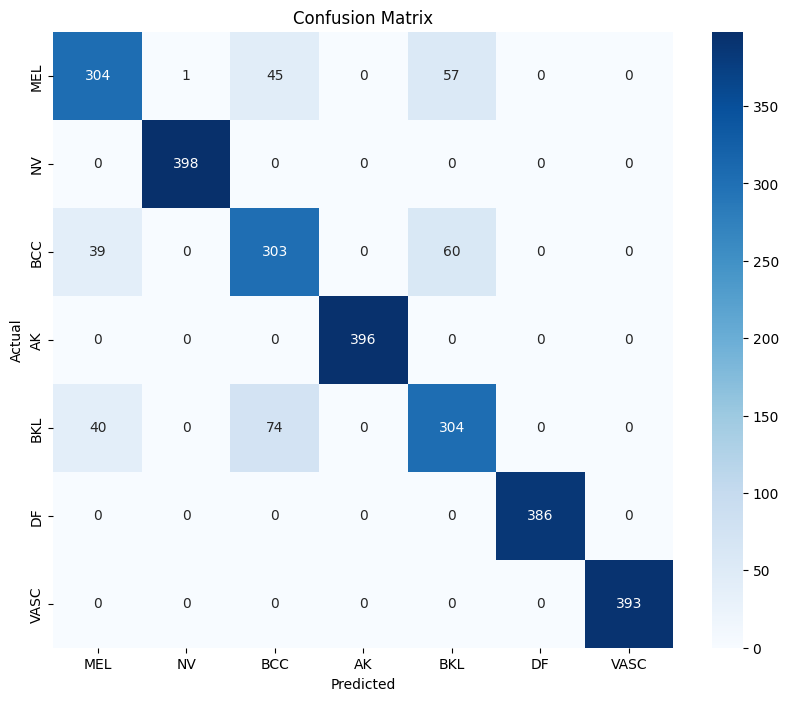

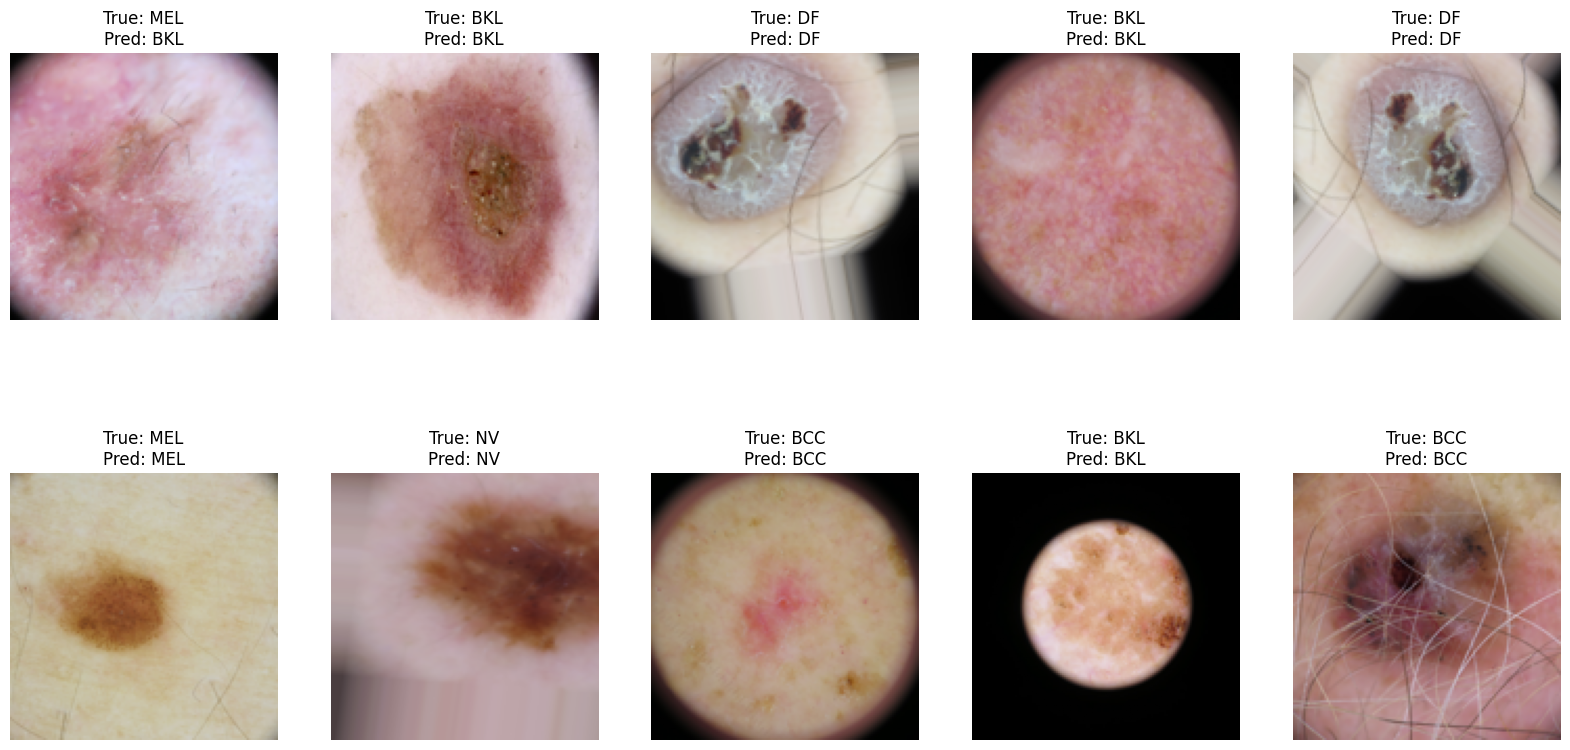

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Model evaluation and predictions
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Xception Test Accuracy: {test_accuracy}")

# Make predictions on the test set
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(test_labels, predicted_classes, target_names=class_names))

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Plot some test images with their predictions and true labels
def plot_sample_images(images, true_labels, pred_labels, class_names, num_images=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        index = np.random.randint(0, len(images))
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[index])
        plt.title(f"True: {class_names[true_labels[index]]}\nPred: {class_names[pred_labels[index]]}")
        plt.axis('off')
    plt.show()

plot_sample_images(test_images, test_labels, predicted_classes, class_names, num_images=10)


19993432/19993432 [==============================] - 1s 0us/step
Epoch 1/30
350/350 [==============================] - 33s 55ms/step - loss: 0.8512 - accuracy: 0.7202 - val_loss: 0.4745 - val_accuracy: 0.8171 - lr: 1.0000e-04
Epoch 2/30
350/350 [==============================] - 13s 36ms/step - loss: 0.5013 - accuracy: 0.8164 - val_loss: 0.4203 - val_accuracy: 0.8382 - lr: 1.0000e-04
Epoch 3/30
350/350 [==============================] - 12s 35ms/step - loss: 0.4241 - accuracy: 0.8375 - val_loss: 0.3996 - val_accuracy: 0.8400 - lr: 1.0000e-04
Epoch 4/30
350/350 [==============================] - 12s 35ms/step - loss: 0.3680 - accuracy: 0.8587 - val_loss: 0.3870 - val_accuracy: 0.8461 - lr: 1.0000e-04
Epoch 5/30
350/350 [==============================] - 13s 36ms/step - loss: 0.3325 - accuracy: 0.8695 - val_loss: 0.3852 - val_accuracy: 0.8414 - lr: 1.0000e-04
Epoch 6/30
350/350 [==============================] - 13s 36ms/step - loss: 0.2933 - accuracy: 0.8808 - val_loss: 0.3713 - val_acc

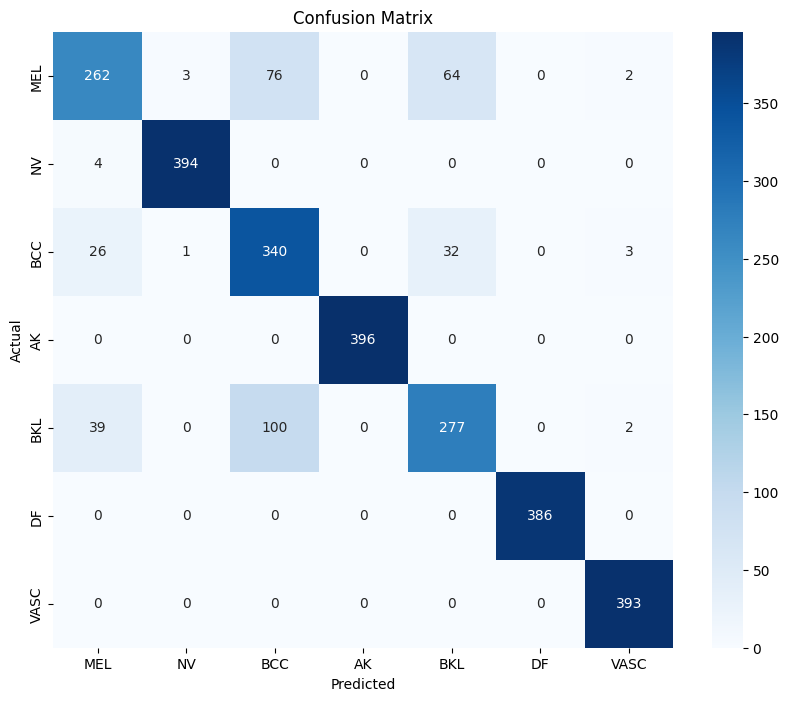

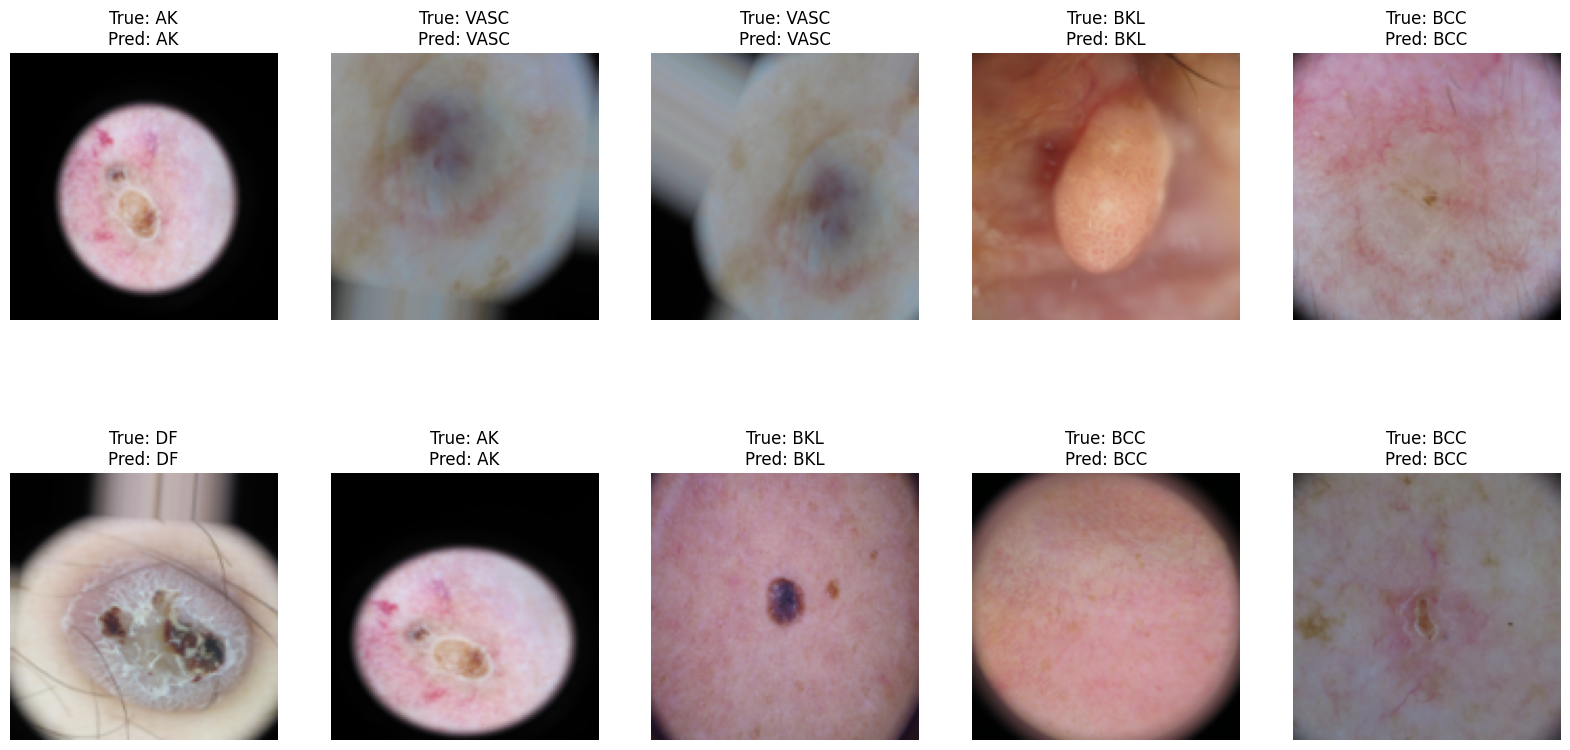

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Hyperparameters
image_size = 128
num_channels = 3
batch_size = 32
initial_lr = 1e-4
num_epochs = 30
num_classes = 7
dropout_rate = 0.5

# Initialize NASNetMobile model
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model (with initial frozen base model)
history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Unfreeze the base model and retrain with a lower learning rate
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr/10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model again
history_fine = model.fit(train_images, train_labels, epochs=num_epochs//2, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print(f"NASNetMobile Test Accuracy: {test_accuracy}")

# Model evaluation and predictions
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"NASNetMobile Test Accuracy: {test_accuracy}")

# Make predictions on the test set
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(test_labels, predicted_classes, target_names=class_names))

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Plot some test images with their predictions and true labels
def plot_sample_images(images, true_labels, pred_labels, class_names, num_images=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        index = np.random.randint(0, len(images))
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[index])
        plt.title(f"True: {class_names[true_labels[index]]}\nPred: {class_names[pred_labels[index]]}")
        plt.axis('off')
    plt.show()

plot_sample_images(test_images, test_labels, predicted_classes, class_names, num_images=10)


9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/30
350/350 [==============================] - 14s 28ms/step - loss: 0.6857 - accuracy: 0.7764 - val_loss: 0.3873 - val_accuracy: 0.8511 - lr: 1.0000e-04
Epoch 2/30
350/350 [==============================] - 7s 19ms/step - loss: 0.4143 - accuracy: 0.8504 - val_loss: 0.3633 - val_accuracy: 0.8629 - lr: 1.0000e-04
Epoch 3/30
350/350 [==============================] - 7s 19ms/step - loss: 0.3438 - accuracy: 0.8712 - val_loss: 0.3461 - val_accuracy: 0.8629 - lr: 1.0000e-04
Epoch 4/30
350/350 [==============================] - 7s 19ms/step - loss: 0.3097 - accuracy: 0.8834 - val_loss: 0.3258 - val_accuracy: 0.8743 - lr: 1.0000e-04
Epoch 5/30
350/350 [==============================] - 7s 19ms/step - loss: 0.2871 - accuracy: 0.8898 - val_loss: 0.3216 - val_accuracy: 0.8714 - lr: 1.0000e-04
Epoch 6/30
350/350 [==============================] - 6s 19ms/step - loss: 0.2556 - accuracy: 0.8950 - val_loss: 0.3160 - val_accuracy: 

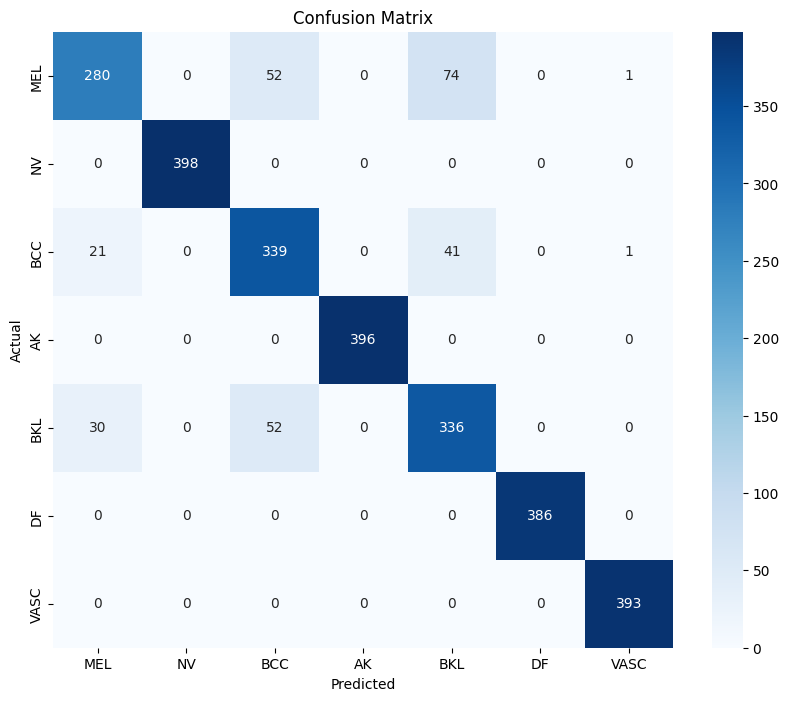

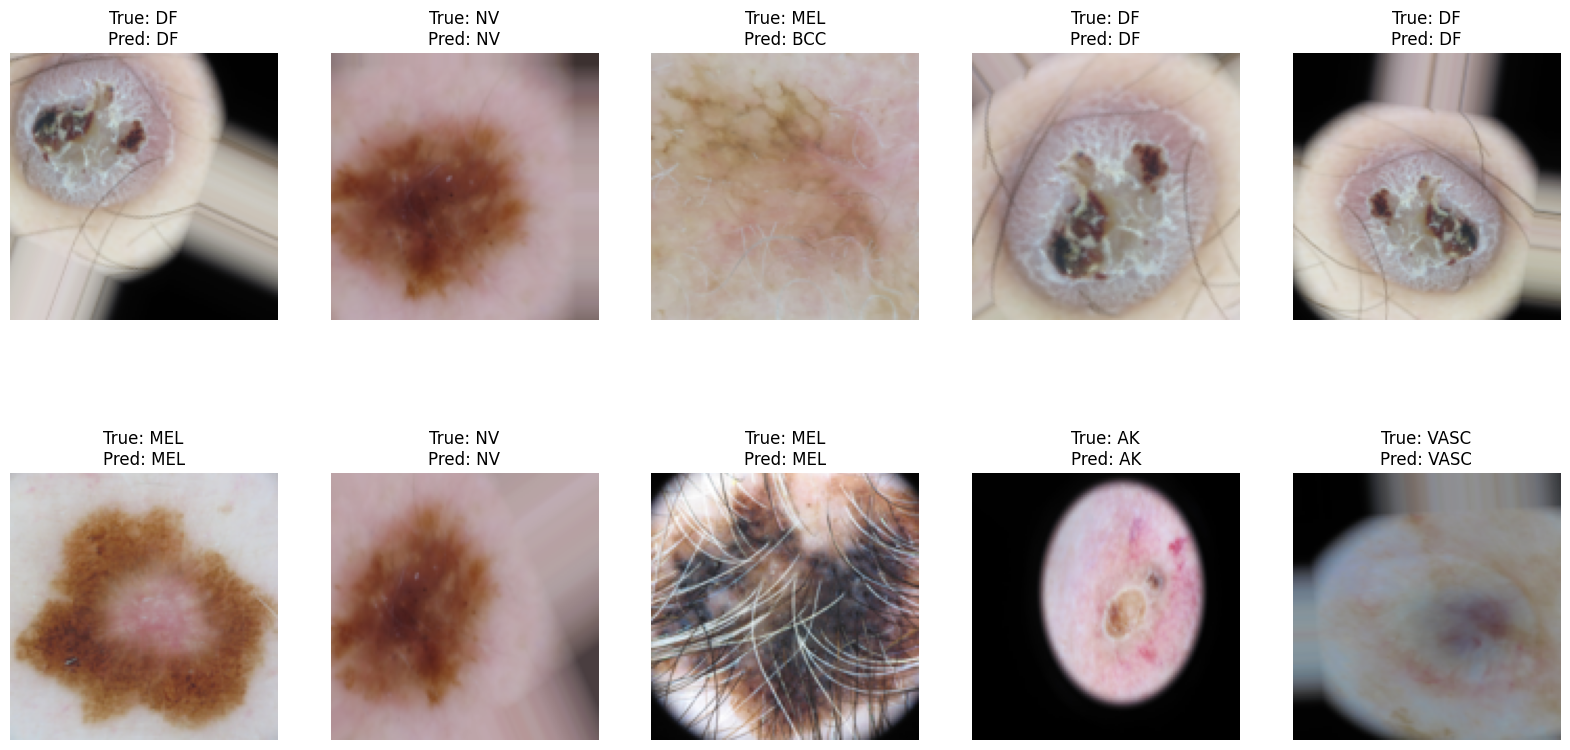

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Hyperparameters
image_size = 128
num_channels = 3
batch_size = 32
initial_lr = 1e-4
num_epochs = 30
num_classes = 7
dropout_rate = 0.5

# Initialize MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model (with initial frozen base model)
history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Unfreeze the base model and retrain with a lower learning rate
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr/10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model again
history_fine = model.fit(train_images, train_labels, epochs=num_epochs//2, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print(f"MobileNetV2 Test Accuracy: {test_accuracy}")

# Model evaluation and predictions
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"MobileNetV2 Test Accuracy: {test_accuracy}")

# Make predictions on the test set
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(test_labels, predicted_classes, target_names=class_names))

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Plot some test images with their predictions and true labels
def plot_sample_images(images, true_labels, pred_labels, class_names, num_images=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        index = np.random.randint(0, len(images))
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[index])
        plt.title(f"True: {class_names[true_labels[index]]}\nPred: {class_names[pred_labels[index]]}")
        plt.axis('off')
    plt.show()

plot_sample_images(test_images, test_labels, predicted_classes, class_names, num_images=10)


In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Hyperparameters
image_size = 128
num_channels = 3
batch_size = 32
initial_lr = 1e-4
num_epochs = 30
num_classes = 7
dropout_rate = 0.5

# Initialize NASNetMobile model
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model (with initial frozen base model)
history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Unfreeze the base model and retrain with a lower learning rate
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr/10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model again
history_fine = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print(f"NASNetMobile Test Accuracy: {test_accuracy}")

Epoch 1/30
350/350 [==============================] - 33s 54ms/step - loss: 0.8769 - accuracy: 0.7191 - val_loss: 0.4624 - val_accuracy: 0.8200 - lr: 1.0000e-04
Epoch 2/30
350/350 [==============================] - 12s 36ms/step - loss: 0.5124 - accuracy: 0.8179 - val_loss: 0.4098 - val_accuracy: 0.8361 - lr: 1.0000e-04
Epoch 3/30
350/350 [==============================] - 13s 36ms/step - loss: 0.4206 - accuracy: 0.8398 - val_loss: 0.4081 - val_accuracy: 0.8371 - lr: 1.0000e-04
Epoch 4/30
350/350 [==============================] - 12s 35ms/step - loss: 0.3730 - accuracy: 0.8554 - val_loss: 0.3800 - val_accuracy: 0.8475 - lr: 1.0000e-04
Epoch 5/30
350/350 [==============================] - 12s 36ms/step - loss: 0.3399 - accuracy: 0.8644 - val_loss: 0.3720 - val_accuracy: 0.8561 - lr: 1.0000e-04
Epoch 6/30
350/350 [==============================] - 12s 35ms/step - loss: 0.3053 - accuracy: 0.8792 - val_loss: 0.3781 - val_accuracy: 0.8550 - lr: 1.0000e-04
Epoch 7/30
350/350 [==============